# ASSIGNMENT 1. ANALYZING THE SHARING ECONOMY WITH AIRBNB DATA

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

df=pd.read_csv("/content/drive/MyDrive/DSO 574_Big Data/Combined Listing Data [Summary].csv")
df

<ipython-input-6-a2e7f5ba54e8>:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("/content/drive/MyDrive/DSO 574_Big Data/Combined Listing Data [Summary].csv")


,Unnamed: 0,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,Scrape File
0,0,3861476,venicelocalliving.com 341,16577861,John,NaN,Venice,33.998202,-118.476196,Entire home/apt,145,1,4,2015-05-08,0.4,10,304.0,los_angeles_2015_05_listings.csv
1,1,6431889,Turquoise Jewel at Venice Beach,18993265,Greg,NaN,Venice,33.985100,-118.469738,Entire home/apt,175,1,0,NaN,NaN,1,76.0,los_angeles_2015_05_listings.csv
2,2,5754633,Terrane Resort - Oceanfront Suite,15241342,Monica,NaN,Rancho Palos Verdes,33.740152,-118.395754,Private room,295,2,0,NaN,NaN,2,310.0,los_angeles_2015_05_listings.csv
3,3,6302541,Hollywood Hot Spot,32776680,Alix,NaN,Hollywood,34.099955,-118.311584,Private room,110,1,0,NaN,NaN,1,362.0,los_angeles_2015_05_listings.csv
4,4,4469657,Main Street Retreat,10658835,Brandon,NaN,Venice,33.997269,-118.478744,Entire home/apt,600,7,0,NaN,NaN,11,328.0,los_angeles_2015_05_listings.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1633605,32170,47389079,Luxury Suite Downtown LA,299035083,Donnie,City of Los Angeles,Downtown,34.047020,-118.260440,Private room,150,30,1,2021-01-03,1.0,1,256.0,los_angeles_2021_01_listings.csv
1633606,32171,47389243,1B1B private entrance big yard near supermarket,372613526,Chia-Chu,Other Cities,Arcadia,34.123990,-118.019270,Private room,45,1,0,NaN,NaN,5,0.0,los_angeles_2021_01_listings.csv
1633607,32172,47389382,"Centinela ONE, 2bd apartment",14936368,Andrija,City of Los Angeles,Mar Vista,34.003460,-118.434800,Entire home/apt,72,30,0,NaN,NaN,4,28.0,los_angeles_2021_01_listings.csv
1633608,32173,47389961,Specious House with basketball court in the yard,372613526,Chia-Chu,Other Cities,Arcadia,34.123400,-118.017890,Entire home/apt,120,3,0,NaN,NaN,5,0.0,los_angeles_2021_01_listings.csv


In [7]:
# Display column names with index numbers
for i, col in enumerate(df.columns):
    print(f"{i}: {col}")

0: Unnamed: 0
1: id
2: name
3: host_id
4: host_name
5: neighbourhood_group
6: neighbourhood
7: latitude
8: longitude
9: room_type
10: price
11: minimum_nights
12: number_of_reviews
13: last_review
14: reviews_per_month
15: calculated_host_listings_count
16: availability_365
17: Scrape File


In [8]:
# Check for missing values
missing_values = df.isnull().sum().sort_values(ascending=False)
print(missing_values)

reviews_per_month                 343955
last_review                       343770
neighbourhood_group               282916
host_name                           6484
name                                 162
availability_365                      14
Unnamed: 0                             0
minimum_nights                         0
calculated_host_listings_count         0
number_of_reviews                      0
room_type                              0
price                                  0
id                                     0
longitude                              0
latitude                               0
neighbourhood                          0
host_id                                0
Scrape File                            0
dtype: int64


## Categorize Comparison Periods
- Column: ComparisonPeriod
  - Values: Pre-COVID=0, During-COVID=1, Regulation=2
  - Pre-COVID (May 2015-Oct 2019) vs. During-COVID (Mar 2020-Jan 2021) vs. Regulation Period (Nov 2019-Feb 2020)

- Column: YearMonth
  - Values: Scrape File's dates

In [9]:
def get_period(scrape_file):
    # Example: "los_angeles_2015_05_listings.csv"
    parts = scrape_file.split('_')
    year = int(parts[2])
    month = int(parts[3])
    # Pre-COVID: May 2015 - October 2019
    if (year < 2019) or (year == 2019 and month <= 10):
        return 0
    # Regulation Period: November 2019 - February 2020
    elif (year == 2019 and month >= 11) or (year == 2020 and month <= 2):
        return 2
    # During-COVID: March 2020 - January 2021
    elif (year == 2020 and month >= 3) or (year == 2021 and month <= 1):
        return 1
    else:
        return None

df['ComparisonPeriod'] = df['Scrape File'].apply(get_period)
print(df['ComparisonPeriod'].value_counts())

# Function to extract Year-Month from Scrape File
def get_year_month(scrape_file):
    parts = scrape_file.split('_')
    return parts[2] + '-' + parts[3]

df['YearMonth'] = df['Scrape File'].apply(get_year_month)

ComparisonPeriod
0    1099697
1     374552
2     159361
Name: count, dtype: int64


# Analysis 1_Total number of Airbnb listings

- Variable: ComparisonPeriod, YearMonth

In [10]:
# Group data by ComparisonPeriod and YearMonth to get monthly counts of listings
monthly_counts = df.groupby(['ComparisonPeriod', 'YearMonth']).size().reset_index(name='Count')

# Compute the average monthly listings for each period
avg_monthly_counts = monthly_counts.groupby('ComparisonPeriod')['Count'].mean().reset_index()
print("Average Monthly Listings by ComparisonPeriod:")
print(avg_monthly_counts)

# Calculate percentage change between Pre-COVID (0) and During-COVID (1)
# (Percent change = ((During-COVID - Pre-COVID) / Pre-COVID) * 100)
pre_covid_avg = avg_monthly_counts.loc[avg_monthly_counts['ComparisonPeriod'] == 0, 'Count'].values[0]
during_covid_avg = avg_monthly_counts.loc[avg_monthly_counts['ComparisonPeriod'] == 1, 'Count'].values[0]
percent_change = ((during_covid_avg - pre_covid_avg) / pre_covid_avg) * 100
print("Percentage change from Pre-COVID to During-COVID: {:.2f}%".format(percent_change))

Average Monthly Listings by ComparisonPeriod:
   ComparisonPeriod         Count
0                 0  35474.096774
1                 1  34050.181818
2                 2  39840.250000
Percentage change from Pre-COVID to During-COVID: -4.01%


In [11]:
# Filter monthly counts for Pre-COVID and During-COVID
pre_covid_counts = monthly_counts[monthly_counts['ComparisonPeriod'] == 0]['Count']
during_covid_counts = monthly_counts[monthly_counts['ComparisonPeriod'] == 1]['Count']

# Perform t-test (using unequal variances)
t_stat, p_value = ttest_ind(pre_covid_counts, during_covid_counts, equal_var=False)

print("T-test comparing Pre-COVID and During-COVID monthly listings:")
print("t-statistic:", t_stat, "p-value:", p_value)

T-test comparing Pre-COVID and During-COVID monthly listings:
t-statistic: 0.6799329623680918 p-value: 0.5006073438311123


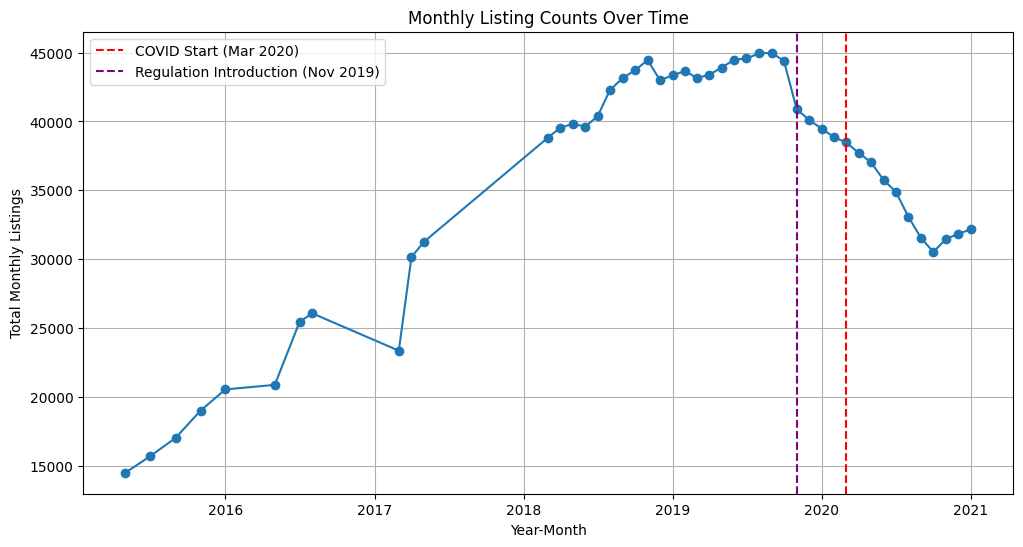

In [12]:
# Group by YearMonth only to get continuous monthly counts over time
monthly_total = df.groupby('YearMonth').size().reset_index(name='TotalCount')

# Convert YearMonth string to datetime for proper ordering
monthly_total['YearMonth_dt'] = pd.to_datetime(monthly_total['YearMonth'], format='%Y-%m')
monthly_total = monthly_total.sort_values('YearMonth_dt')

# Plot the continuous line chart with grid lines
plt.figure(figsize=(12,6))
plt.plot(monthly_total['YearMonth_dt'], monthly_total['TotalCount'], marker='o', linestyle='-')

# Add vertical line for COVID start (March 2020)
covid_start = pd.to_datetime("2020-03", format="%Y-%m")
plt.axvline(covid_start, color='red', linestyle='--', label='COVID Start (Mar 2020)')

# Add vertical line for Regulation Introduction (November 2019)
regulation_end = pd.to_datetime("2019-11", format="%Y-%m")
plt.axvline(regulation_end, color='purple', linestyle='--', label='Regulation Introduction (Nov 2019)')

plt.xlabel('Year-Month')
plt.ylabel('Total Monthly Listings')
plt.title('Monthly Listing Counts Over Time')
plt.legend()
plt.grid(True)
plt.show()

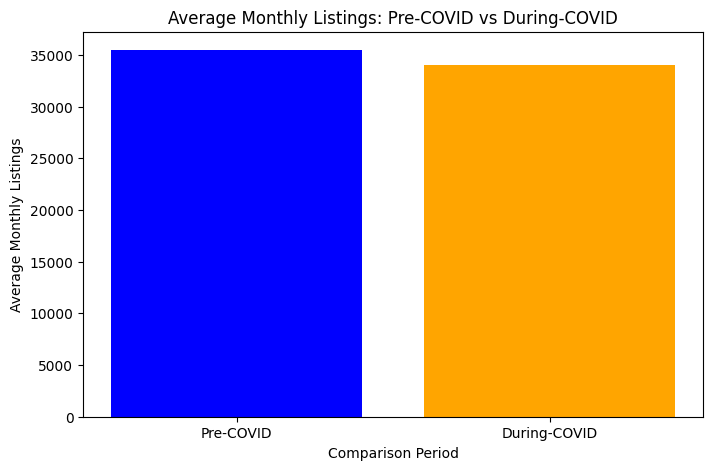

In [13]:
# Visualize only Pre-COVID and During-COVID
filtered_avg = avg_monthly_counts[avg_monthly_counts['ComparisonPeriod'].isin([0,1])]
plt.figure(figsize=(8,5))
plt.bar(filtered_avg['ComparisonPeriod'].replace({0:'Pre-COVID', 1:'During-COVID'}),
        filtered_avg['Count'], color=['blue','orange'])
plt.xlabel('Comparison Period')
plt.ylabel('Average Monthly Listings')
plt.title('Average Monthly Listings: Pre-COVID vs During-COVID')
plt.show()

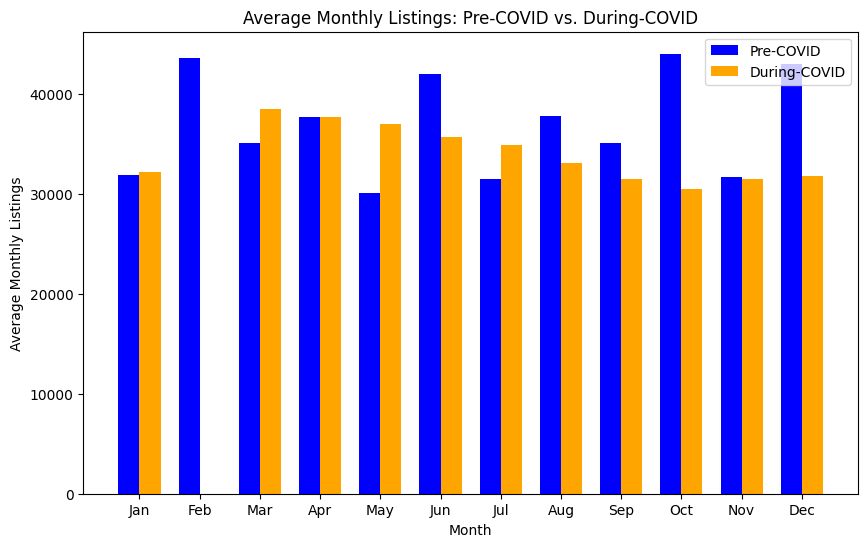

In [14]:
# Convert YearMonth to datetime and extract month
monthly_counts['YearMonth_dt'] = pd.to_datetime(monthly_counts['YearMonth'], format='%Y-%m')
monthly_counts['Month'] = monthly_counts['YearMonth_dt'].dt.month

# Filter for Pre-COVID (0) and During-COVID (1) and compute average counts by month
monthly_avg = monthly_counts[monthly_counts['ComparisonPeriod'].isin([0,1])].groupby(['Month','ComparisonPeriod'])['Count'].mean().unstack()

# Plot side-by-side bar chart with consistent colors
x = np.arange(len(monthly_avg))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, monthly_avg[0], width, label='Pre-COVID', color='blue')
plt.bar(x + width/2, monthly_avg[1], width, label='During-COVID', color='orange')
plt.xticks(x, [pd.to_datetime(str(m), format='%m').strftime('%b') for m in monthly_avg.index])
plt.xlabel('Month')
plt.ylabel('Average Monthly Listings')
plt.title('Average Monthly Listings: Pre-COVID vs. During-COVID')
plt.legend()
plt.show()

# Analysis 2_Average number of days available

- Variable: availability_365

In [15]:
# Drop rows with null values in the availability_365 column
df_clean = df.dropna(subset=['availability_365'])
print(f"Remaining rows after dropping nulls: {len(df_clean)}")

Remaining rows after dropping nulls: 1633596


In [11]:
# Calculate average availability_365 for Pre-COVID (ComparisonPeriod == 0) and During-COVID (ComparisonPeriod == 1)
pre_covid_avail = df_clean[df_clean['ComparisonPeriod'] == 0]['availability_365'].mean()
during_covid_avail = df_clean[df_clean['ComparisonPeriod'] == 1]['availability_365'].mean()

print("Average availability_365 (Pre-COVID):", pre_covid_avail)
print("Average availability_365 (During-COVID):", during_covid_avail)

# Calculate percentage change (negative indicates a decrease)
percent_change_avail = ((during_covid_avail - pre_covid_avail) / pre_covid_avail) * 100
print("Percentage change in availability_365: {:.2f}%".format(percent_change_avail))

Average availability_365 (Pre-COVID): 182.9453342463237
Average availability_365 (During-COVID): 168.4198936329268
Percentage change in availability_365: -7.94%


In [12]:
# Optional: Conduct a t-test to statistically compare the two periods
from scipy.stats import ttest_ind
pre_avail = df_clean[df_clean['ComparisonPeriod'] == 0]['availability_365']
during_avail = df_clean[df_clean['ComparisonPeriod'] == 1]['availability_365']
t_stat, p_value = ttest_ind(pre_avail, during_avail, equal_var=False)
print("T-test comparing availability_365 (Pre vs During): t-statistic = {:.2f}, p-value = {:.3f}".format(t_stat, p_value))

T-test comparing availability_365 (Pre vs During): t-statistic = 54.14, p-value = 0.000


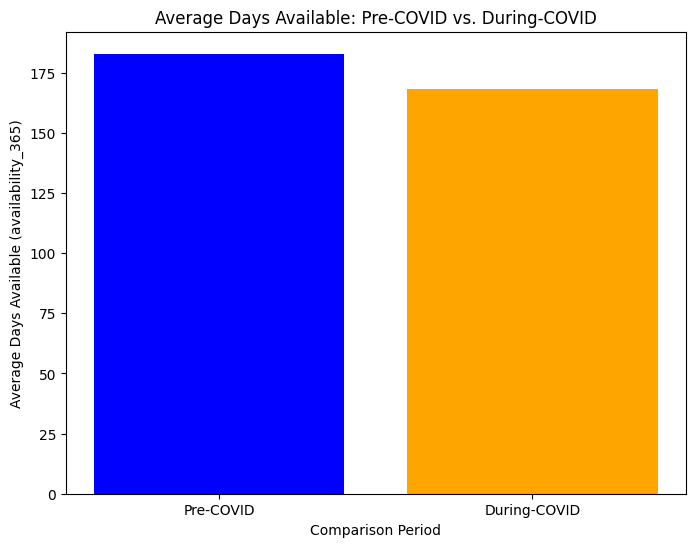

In [13]:
# Compute mean and standard deviation for availability_365 for Pre-COVID (0) and During-COVID (1)
avail_stats = df_clean[df_clean['ComparisonPeriod'].isin([0,1])].groupby('ComparisonPeriod')['availability_365'].agg(['mean', 'std']).reset_index()
avail_stats['Period'] = avail_stats['ComparisonPeriod'].replace({0: 'Pre-COVID', 1: 'During-COVID'})

# Plot the bar chart
plt.figure(figsize=(8,6))
plt.bar(avail_stats['Period'], avail_stats['mean'], color=['blue', 'orange'])
plt.xlabel('Comparison Period')
plt.ylabel('Average Days Available (availability_365)')
plt.title('Average Days Available: Pre-COVID vs. During-COVID')
plt.show()

<ipython-input-14-4c06f0ca8082>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['YearMonth'] = df_clean['Scrape File'].apply(lambda x: x.split('_')[2] + '-' + x.split('_')[3])
<ipython-input-14-4c06f0ca8082>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['YearMonth_dt'] = pd.to_datetime(df_clean['YearMonth'], format='%Y-%m')
<ipython-input-14-4c06f0ca8082>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

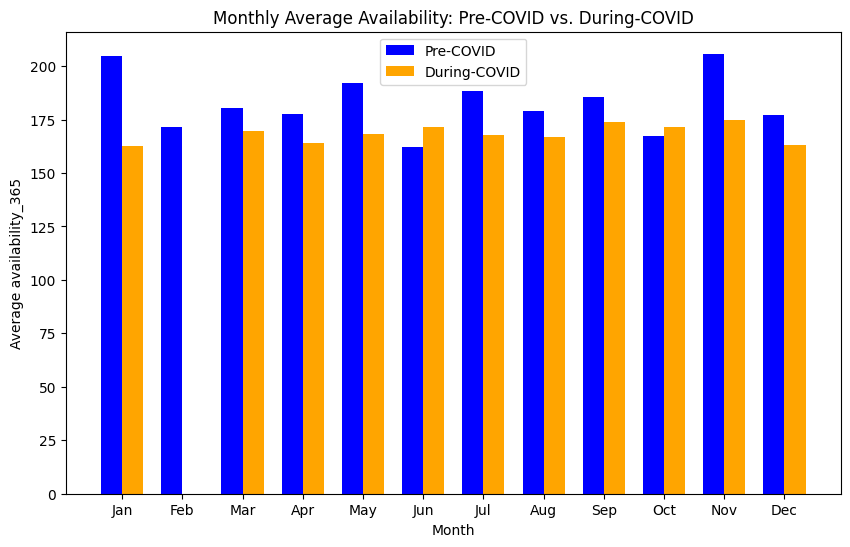

In [14]:
# Create a YearMonth column in df_clean if not already created
df_clean['YearMonth'] = df_clean['Scrape File'].apply(lambda x: x.split('_')[2] + '-' + x.split('_')[3])
df_clean['YearMonth_dt'] = pd.to_datetime(df_clean['YearMonth'], format='%Y-%m')
df_clean['Month'] = df_clean['YearMonth_dt'].dt.month

# Filter for Pre-COVID (0) and During-COVID (1) and compute average availability per month
monthly_avail = df_clean[df_clean['ComparisonPeriod'].isin([0,1])].groupby(['Month', 'ComparisonPeriod'])['availability_365'].mean().unstack()

x = np.arange(len(monthly_avail.index))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, monthly_avail[0], width, label='Pre-COVID', color='blue')
plt.bar(x + width/2, monthly_avail[1], width, label='During-COVID', color='orange')
plt.xticks(x, [pd.to_datetime(str(m), format='%m').strftime('%b') for m in monthly_avail.index])
plt.xlabel('Month')
plt.ylabel('Average availability_365')
plt.title('Monthly Average Availability: Pre-COVID vs. During-COVID')
plt.legend()
plt.show()

# Analysis 3_Minimum nights

- Variable: minimum_nights

In [15]:
# Calculate the average minimum nights for Pre-COVID (ComparisonPeriod == 0) and During-COVID (ComparisonPeriod == 1)
pre_covid_min = df_clean[df_clean['ComparisonPeriod'] == 0]['minimum_nights'].mean()
during_covid_min = df_clean[df_clean['ComparisonPeriod'] == 1]['minimum_nights'].mean()

print("Average minimum nights (Pre-COVID):", pre_covid_min)
print("Average minimum nights (During-COVID):", during_covid_min)

# Calculate percentage change (an increase should result in a positive value)
percent_change_min = ((during_covid_min - pre_covid_min) / pre_covid_min) * 100
print("Percentage change in minimum nights: {:.2f}%".format(percent_change_min))

Average minimum nights (Pre-COVID): 4.684252643716416
Average minimum nights (During-COVID): 15.262655118648413
Percentage change in minimum nights: 225.83%


In [16]:
# Optional: Perform a t-test to check if the difference is statistically significant
from scipy.stats import ttest_ind
pre_min = df_clean[df_clean['ComparisonPeriod'] == 0]['minimum_nights']
during_min = df_clean[df_clean['ComparisonPeriod'] == 1]['minimum_nights']
t_stat, p_value = ttest_ind(pre_min, during_min, equal_var=False)
print("T-test comparing minimum_nights: t-statistic = {:.2f}, p-value = {:.3f}".format(t_stat, p_value))

T-test comparing minimum_nights: t-statistic = -203.21, p-value = 0.000


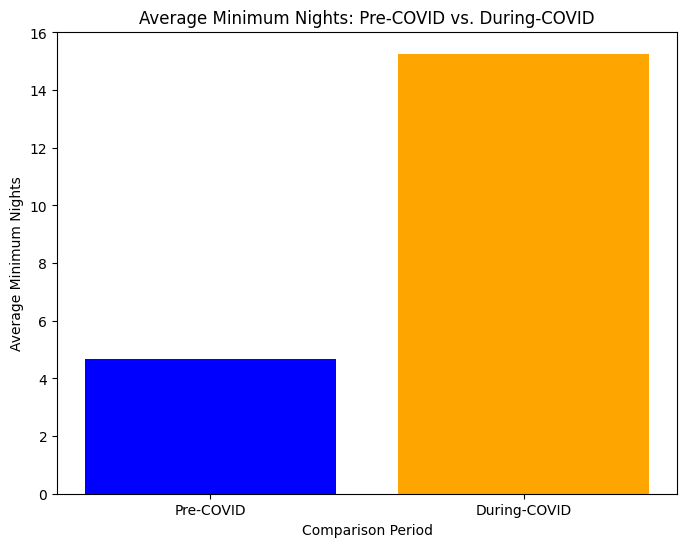

In [17]:
# Visualization: Create a bar chart comparing the two periods with consistent colors
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.bar(['Pre-COVID', 'During-COVID'], [pre_covid_min, during_covid_min], color=['blue', 'orange'])
plt.xlabel('Comparison Period')
plt.ylabel('Average Minimum Nights')
plt.title('Average Minimum Nights: Pre-COVID vs. During-COVID')
plt.show()

<ipython-input-18-7bcced4b933b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['YearMonth'] = df_clean['Scrape File'].apply(lambda x: x.split('_')[2] + '-' + x.split('_')[3])
<ipython-input-18-7bcced4b933b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['YearMonth_dt'] = pd.to_datetime(df_clean['YearMonth'], format='%Y-%m')
<ipython-input-18-7bcced4b933b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

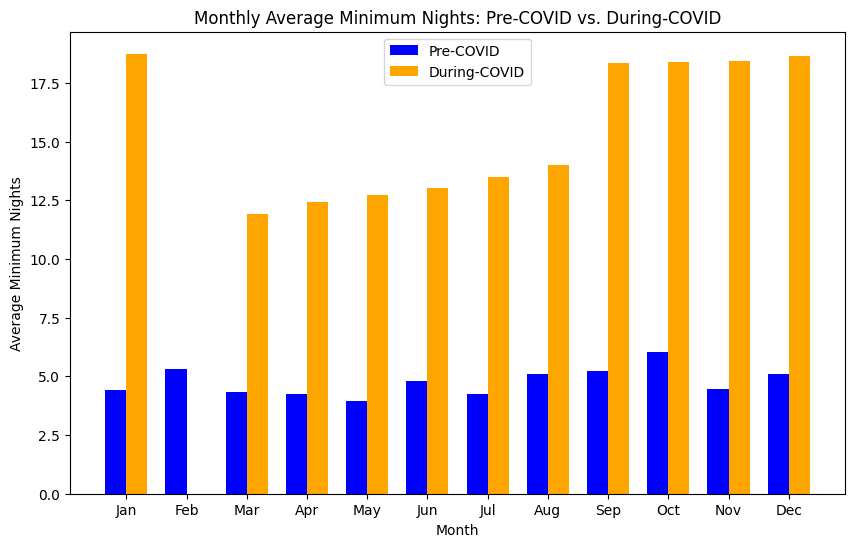

In [18]:
# Create a YearMonth column and extract the month number in df_clean
df_clean['YearMonth'] = df_clean['Scrape File'].apply(lambda x: x.split('_')[2] + '-' + x.split('_')[3])
df_clean['YearMonth_dt'] = pd.to_datetime(df_clean['YearMonth'], format='%Y-%m')
df_clean['Month'] = df_clean['YearMonth_dt'].dt.month

# Filter for Pre-COVID (0) and During-COVID (1) and compute average minimum nights per month
monthly_min_nights = df_clean[df_clean['ComparisonPeriod'].isin([0,1])].groupby(['Month', 'ComparisonPeriod'])['minimum_nights'].mean().unstack()

x = np.arange(len(monthly_min_nights.index))  # positions for each month
width = 0.35  # width of the bars

plt.figure(figsize=(10,6))
plt.bar(x - width/2, monthly_min_nights[0], width, label='Pre-COVID', color='blue')
plt.bar(x + width/2, monthly_min_nights[1], width, label='During-COVID', color='orange')
plt.xticks(x, [pd.to_datetime(str(m), format='%m').strftime('%b') for m in monthly_min_nights.index])
plt.xlabel('Month')
plt.ylabel('Average Minimum Nights')
plt.title('Monthly Average Minimum Nights: Pre-COVID vs. During-COVID')
plt.legend()
plt.show()

In [19]:
# Compute average minimum nights per month for Pre-COVID (0) and During-COVID (1)
monthly_min = df_clean[df_clean['ComparisonPeriod'].isin([0,1])].groupby(['Month', 'ComparisonPeriod'])['minimum_nights'].mean().unstack()

# Calculate percentage difference: ((During-COVID - Pre-COVID) / Pre-COVID) * 100 for each month
monthly_min['PctChange'] = ((monthly_min[1] - monthly_min[0]) / monthly_min[0]) * 100

print(monthly_min[['PctChange']])

ComparisonPeriod   PctChange
Month                       
1                 322.547459
2                        NaN
3                 175.193830
4                 190.878731
5                 223.449488
6                 170.343067
7                 217.233373
8                 173.450672
9                 250.330573
10                205.567254
11                314.485432
12                264.919306


# Analysis 4_Listing price

- Variable: price

In [20]:
# Calculate the average price for Pre-COVID (ComparisonPeriod == 0) and During-COVID (ComparisonPeriod == 1)
pre_covid_price = df_clean[df_clean['ComparisonPeriod'] == 0]['price'].mean()
during_covid_price = df_clean[df_clean['ComparisonPeriod'] == 1]['price'].mean()

print("Average price (Pre-COVID):", pre_covid_price)
print("Average price (During-COVID):", during_covid_price)

# Calculate percentage change (negative indicates a decrease)
percent_change_price = ((during_covid_price - pre_covid_price) / pre_covid_price) * 100
print("Percentage change in price from Pre-COVID to During-COVID: {:.2f}%".format(percent_change_price))

Average price (Pre-COVID): 195.5182338910395
Average price (During-COVID): 225.87271460304578
Percentage change in price from Pre-COVID to During-COVID: 15.53%


In [21]:
# Perform a t-test to assess if the difference is statistically significant
from scipy.stats import ttest_ind
pre_price = df_clean[df_clean['ComparisonPeriod'] == 0]['price']
during_price = df_clean[df_clean['ComparisonPeriod'] == 1]['price']
t_stat, p_value = ttest_ind(pre_price, during_price, equal_var=False)
print("T-test comparing price (Pre vs. During): t-statistic = {:.2f}, p-value = {:.3f}".format(t_stat, p_value))

T-test comparing price (Pre vs. During): t-statistic = -26.31, p-value = 0.000


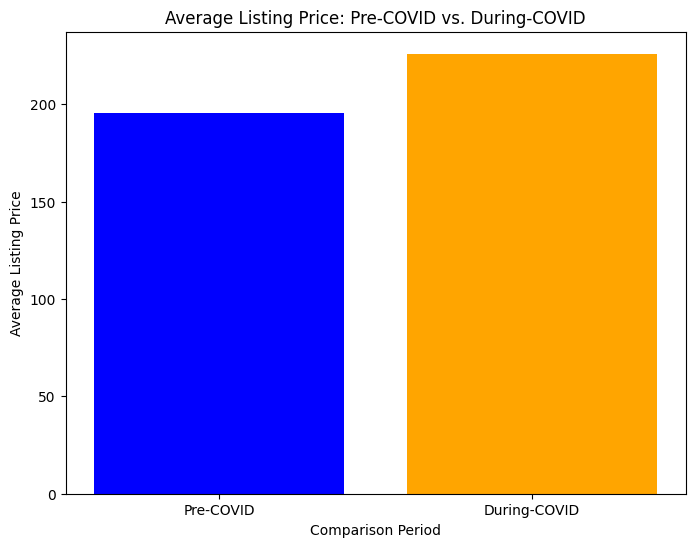

In [22]:
# Visualization: Create a bar chart comparing the two periods (blue for Pre-COVID, orange for During-COVID)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.bar(['Pre-COVID', 'During-COVID'], [pre_covid_price, during_covid_price], color=['blue', 'orange'])
plt.xlabel('Comparison Period')
plt.ylabel('Average Listing Price')
plt.title('Average Listing Price: Pre-COVID vs. During-COVID')
plt.show()

<ipython-input-23-cf941ca38fdc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['YearMonth'] = df_clean['Scrape File'].apply(lambda x: x.split('_')[2] + '-' + x.split('_')[3])
<ipython-input-23-cf941ca38fdc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['YearMonth_dt'] = pd.to_datetime(df_clean['YearMonth'], format='%Y-%m')
<ipython-input-23-cf941ca38fdc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

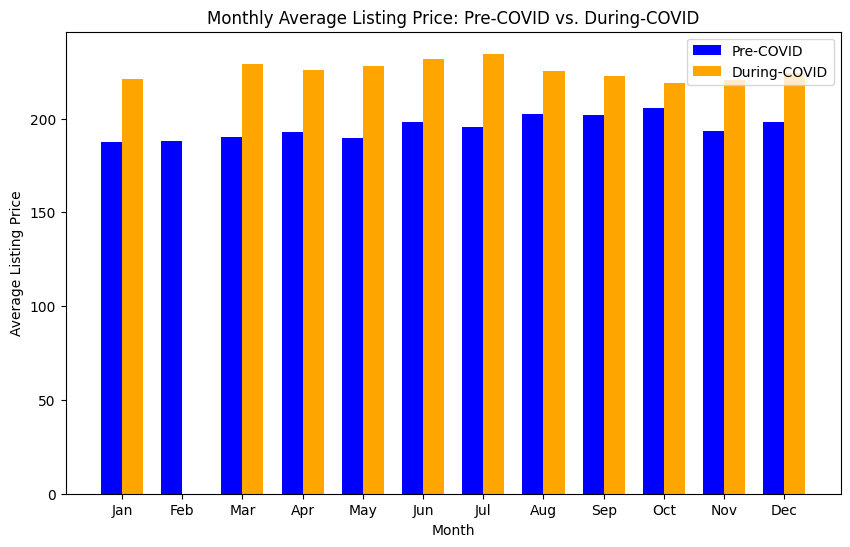

In [23]:
# Create YearMonth and Month columns in df_clean
df_clean['YearMonth'] = df_clean['Scrape File'].apply(lambda x: x.split('_')[2] + '-' + x.split('_')[3])
df_clean['YearMonth_dt'] = pd.to_datetime(df_clean['YearMonth'], format='%Y-%m')
df_clean['Month'] = df_clean['YearMonth_dt'].dt.month

# Filter for Pre-COVID (ComparisonPeriod==0) and During-COVID (ComparisonPeriod==1), then compute average price by month
monthly_price = df_clean[df_clean['ComparisonPeriod'].isin([0, 1])].groupby(['Month','ComparisonPeriod'])['price'].mean().unstack()

x = np.arange(len(monthly_price.index))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, monthly_price[0], width, label='Pre-COVID', color='blue')
plt.bar(x + width/2, monthly_price[1], width, label='During-COVID', color='orange')
plt.xticks(x, [pd.to_datetime(str(m), format='%m').strftime('%b') for m in monthly_price.index])
plt.xlabel('Month')
plt.ylabel('Average Listing Price')
plt.title('Monthly Average Listing Price: Pre-COVID vs. During-COVID')
plt.legend()
plt.show()

# Analysis 5_Number of listings managed by a single host

- Variable: calculated_host_listings_count

In [24]:
# Group the dataset by host_id and count unique values in calculated_host_listings_count for each host
unique_counts = df_clean.groupby('host_id')['calculated_host_listings_count'].nunique()

# Identify hosts where the count is more than 1 (which would indicate inconsistency)
inconsistent_hosts = unique_counts[unique_counts > 1]

if not inconsistent_hosts.empty:
    print("Inconsistent calculated_host_listings_count values found for these hosts:")
    print(inconsistent_hosts)
else:
    print("All hosts have consistent calculated_host_listings_count values.")

Inconsistent calculated_host_listings_count values found for these hosts:
host_id
42           2
2591         3
3008         2
3144         2
3199         2
            ..
378402263    2
378487624    2
378859287    2
378875225    2
378912746    2
Name: calculated_host_listings_count, Length: 15499, dtype: int64


In [25]:
# Calculate the number of listings per host based on the dataset
computed_counts = df.groupby('host_id').size().reset_index(name='computed_listings_count')

# Merge computed counts back into the original dataframe for comparison
df_merged = df.merge(computed_counts, on='host_id', how='left')

# Identify rows where the computed count differs from the reported value
discrepancies = df_merged[df_merged['computed_listings_count'] != df_merged['calculated_host_listings_count']]
print("Discrepancies found:")
print(discrepancies[['host_id', 'calculated_host_listings_count', 'computed_listings_count']].drop_duplicates())

# Optionally, use the computed counts for further analysis


Discrepancies found:
           host_id  calculated_host_listings_count  computed_listings_count
0         16577861                              10                      160
1         18993265                               1                       80
2         15241342                               2                       87
3         32776680                               1                        4
4         10658835                              11                      569
...            ...                             ...                      ...
1632963   63980743                               1                       60
1633262  368502987                               2                        5
1633331    5615582                               3                       64
1633405   36633565                               1                        6
1633463  378382773                               3                        4

[92788 rows x 3 columns]


In [26]:
# Filter for Pre-COVID and During-COVID periods only
df_precovid = df[df['ComparisonPeriod'] == 0]
df_covid = df[df['ComparisonPeriod'] == 1]

# Group by host_id and count the number of listings (rows) in each period
precovid_counts = df_precovid.groupby('host_id').size().reset_index(name='precovid_listings_count')
covid_counts = df_covid.groupby('host_id').size().reset_index(name='covid_listings_count')

# Merge the two counts on host_id
host_counts = pd.merge(precovid_counts, covid_counts, on='host_id', how='outer').fillna(0)

# Convert counts to integers
host_counts['precovid_listings_count'] = host_counts['precovid_listings_count'].astype(int)
host_counts['covid_listings_count'] = host_counts['covid_listings_count'].astype(int)

# Display the first few rows to check the results
host_counts

,host_id,precovid_listings_count,covid_listings_count
0,42,7,0
1,59,26,0
2,63,1,0
3,521,31,11
4,583,8,0
...,...,...,...
71080,382259772,0,1
71081,382272569,0,1
71082,382328109,0,1
71083,382335166,0,1


# Analysis 6_Number of reviews

- Variable: reviews_per_month

In [27]:
# Replace NaN values in reviews_per_month with 0 (indicating no reviews)
df_clean['reviews_per_month'].fillna(0, inplace=True)

# Check again for missing values to confirm
print(df_clean['reviews_per_month'].isnull().sum())

0


<ipython-input-27-08224b519a69>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['reviews_per_month'].fillna(0, inplace=True)
<ipython-input-27-08224b519a69>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['reviews_per_month'].fillna(0, inplace=True)


In [28]:
#Calculate the average reviews per month for Pre-COVID and During-COVID
pre_covid_reviews = df_clean[df_clean['ComparisonPeriod'] == 0]['reviews_per_month'].mean()
during_covid_reviews = df_clean[df_clean['ComparisonPeriod'] == 1]['reviews_per_month'].mean()

print("Average reviews per month (Pre-COVID):", pre_covid_reviews)
print("Average reviews per month (During-COVID):", during_covid_reviews)

# Calculate percentage change
percent_change_reviews = ((during_covid_reviews - pre_covid_reviews) / pre_covid_reviews) * 100
print("Percentage change in reviews per month from Pre-COVID to During-COVID: {:.2f}%".format(percent_change_reviews))

Average reviews per month (Pre-COVID): 1.4763904597961417
Average reviews per month (During-COVID): 1.2149032978064458
Percentage change in reviews per month from Pre-COVID to During-COVID: -17.71%


In [29]:
#Perform a t-test to see if the difference is statistically significant
from scipy.stats import ttest_ind
pre_reviews = df_clean[df_clean['ComparisonPeriod'] == 0]['reviews_per_month']
during_reviews = df_clean[df_clean['ComparisonPeriod'] == 1]['reviews_per_month']
t_stat, p_value = ttest_ind(pre_reviews, during_reviews, equal_var=False)
print("T-test comparing reviews_per_month (Pre vs. During): t-statistic = {:.2f}, p-value = {:.3f}".format(t_stat, p_value))

T-test comparing reviews_per_month (Pre vs. During): t-statistic = 79.45, p-value = 0.000


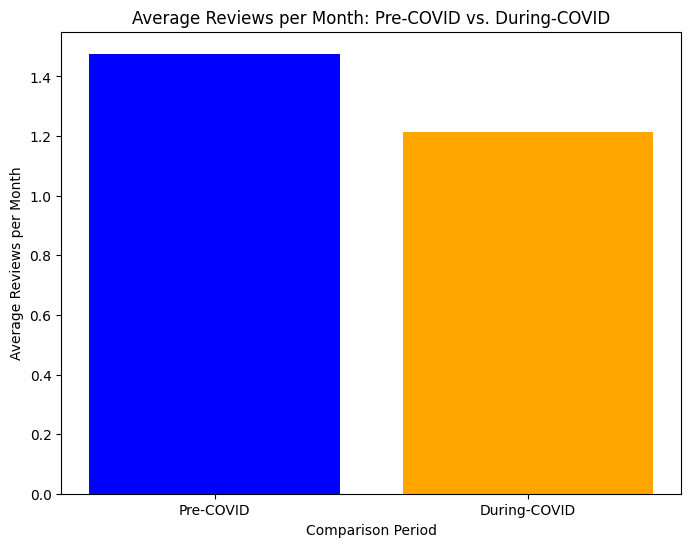

In [30]:
# Simple bar chart to compare average reviews per month
plt.figure(figsize=(8,6))
plt.bar(['Pre-COVID', 'During-COVID'], [pre_covid_reviews, during_covid_reviews], color=['blue', 'orange'])
plt.xlabel('Comparison Period')
plt.ylabel('Average Reviews per Month')
plt.title('Average Reviews per Month: Pre-COVID vs. During-COVID')
plt.show()

<ipython-input-31-e895694faafb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Month'] = df_clean['YearMonth_dt'].dt.month


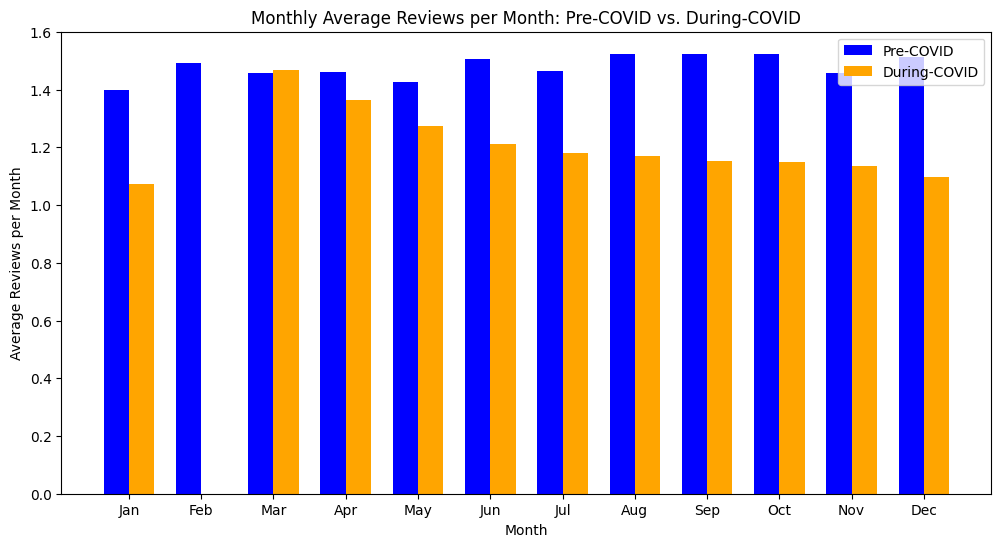

In [31]:
# Extract month from YearMonth for grouping
df_clean['Month'] = df_clean['YearMonth_dt'].dt.month

# Filter for Pre-COVID (0) and During-COVID (1) and compute average reviews per month for each month
monthly_reviews = df_clean[df_clean['ComparisonPeriod'].isin([0, 1])].groupby(['Month', 'ComparisonPeriod'])['reviews_per_month'].mean().unstack()

x = np.arange(len(monthly_reviews.index))  # Positions for each month
width = 0.35  # Width of each bar

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, monthly_reviews[0], width, label='Pre-COVID', color='blue')
plt.bar(x + width/2, monthly_reviews[1], width, label='During-COVID', color='orange')

# Formatting the plot
plt.xticks(x, [pd.to_datetime(str(m), format='%m').strftime('%b') for m in monthly_reviews.index])
plt.xlabel('Month')
plt.ylabel('Average Reviews per Month')
plt.title('Monthly Average Reviews per Month: Pre-COVID vs. During-COVID')
plt.legend()
plt.show()

# Analysis 7_Room Type

- Variable: room_type


In [32]:
# Check unique values in the room_type column
unique_room_types = df_clean['room_type'].unique()
print("Unique room types:", unique_room_types)

Unique room types: ['Entire home/apt' 'Private room' 'Shared room' 'Hotel room']


In [33]:
# Reclassify room types into two categories: 'Entire Space' vs. 'Room'
df_clean['room_category'] = df_clean['room_type'].apply(lambda x: 'Entire Space' if x in ['Entire home/apt', 'Hotel room'] else 'Room')

# Count the number of listings for each room category by period
room_type_counts = df_clean[df_clean['ComparisonPeriod'].isin([0, 1])].groupby(['ComparisonPeriod', 'room_category']).size().unstack()

# Calculate proportions for each period
room_type_proportions = room_type_counts.div(room_type_counts.sum(axis=1), axis=0)

print("Room Type Proportions by Comparison Period:\n", room_type_proportions)

# Calculate percentage change in proportion
percent_change_room = ((room_type_proportions.loc[1] - room_type_proportions.loc[0]) / room_type_proportions.loc[0]) * 100
print("Percentage change in room type proportions from Pre-COVID to During-COVID:\n", percent_change_room)

<ipython-input-33-c9f4d0809fe1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['room_category'] = df_clean['room_type'].apply(lambda x: 'Entire Space' if x in ['Entire home/apt', 'Hotel room'] else 'Room')


Room Type Proportions by Comparison Period:
 room_category     Entire Space      Room
ComparisonPeriod                        
0                     0.613061  0.386939
1                     0.641804  0.358196
Percentage change in room type proportions from Pre-COVID to During-COVID:
 room_category
Entire Space    4.688415
Room           -7.428270
dtype: float64


In [34]:
# Perform a t-test to compare the proportion of 'Entire Space' between Pre-COVID and During-COVID
from scipy.stats import ttest_ind
entire_space_pre = df_clean[(df_clean['ComparisonPeriod'] == 0) & (df_clean['room_category'] == 'Entire Space')]
entire_space_during = df_clean[(df_clean['ComparisonPeriod'] == 1) & (df_clean['room_category'] == 'Entire Space')]

room_pre = df_clean[(df_clean['ComparisonPeriod'] == 0) & (df_clean['room_category'] == 'Room')]
room_during = df_clean[(df_clean['ComparisonPeriod'] == 1) & (df_clean['room_category'] == 'Room')]

# T-test
t_stat, p_value = ttest_ind(entire_space_pre['price'], entire_space_during['price'], equal_var=False)
print("T-test comparing Entire Space prices (Pre vs. During): t-statistic = {:.2f}, p-value = {:.3f}".format(t_stat, p_value))

T-test comparing Entire Space prices (Pre vs. During): t-statistic = -17.14, p-value = 0.000


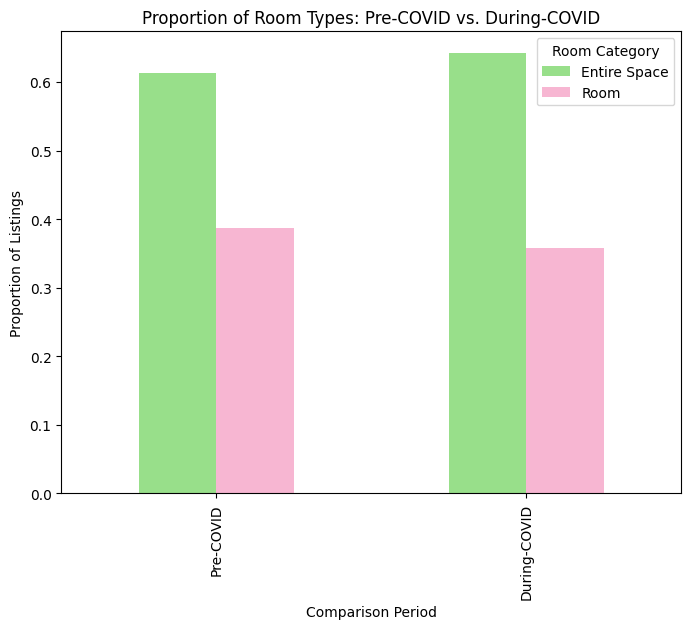

In [35]:
# Visualization: Side-by-side bar chart for room type proportions
import matplotlib.pyplot as plt

room_type_proportions_plot = room_type_proportions.rename(index={0: 'Pre-COVID', 1: 'During-COVID'})
room_type_proportions_plot.plot(kind='bar', figsize=(8,6), color=['#98df8a', '#f7b6d2'])
plt.title('Proportion of Room Types: Pre-COVID vs. During-COVID')
plt.xlabel('Comparison Period')
plt.ylabel('Proportion of Listings')
plt.legend(title='Room Category')
plt.show()

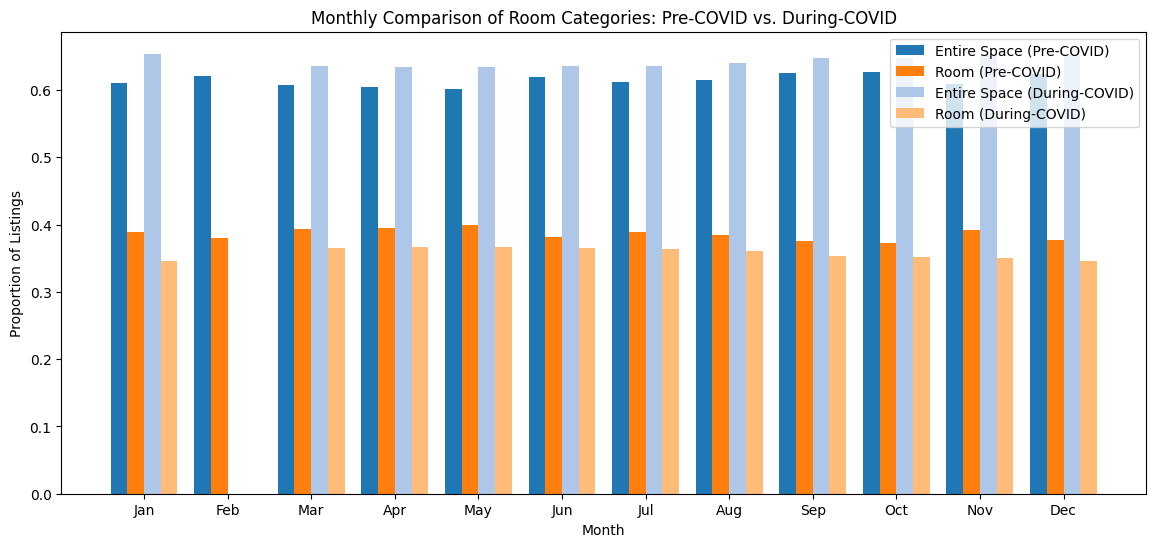

In [36]:
# Fix the warning by using .loc[]
df_clean.loc[:, 'Month'] = df_clean['YearMonth_dt'].dt.month

# Filter for Pre-COVID (0) and During-COVID (1)
filtered_room_data = df_clean[df_clean['ComparisonPeriod'].isin([0, 1])]

# Group by Month and Room Category and calculate proportions
monthly_room_counts = filtered_room_data.groupby(['Month', 'ComparisonPeriod', 'room_category']).size().unstack(fill_value=0)
monthly_room_proportions = monthly_room_counts.div(monthly_room_counts.sum(axis=1), axis=0)

# Separate data for Pre-COVID and During-COVID without reindexing
pre_covid = monthly_room_proportions.xs(0, level='ComparisonPeriod')
during_covid = monthly_room_proportions.xs(1, level='ComparisonPeriod')

# Ensure months align for plotting
all_months = sorted(set(pre_covid.index).union(set(during_covid.index)))
x = np.arange(len(all_months))
width = 0.2

# Plotting
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 6))
# Plotting Pre-COVID
plt.bar(x - width, pre_covid.reindex(all_months, fill_value=0)['Entire Space'], width, label='Entire Space (Pre-COVID)', color='#1f77b4')
plt.bar(x, pre_covid.reindex(all_months, fill_value=0)['Room'], width, label='Room (Pre-COVID)', color='#ff7f0e')

# Plotting During-COVID
plt.bar(x + width, during_covid.reindex(all_months, fill_value=0)['Entire Space'], width, label='Entire Space (During-COVID)', color='#aec7e8')
plt.bar(x + 2*width, during_covid.reindex(all_months, fill_value=0)['Room'], width, label='Room (During-COVID)', color='#ffbb78')

# Formatting
plt.xticks(x + width/2, [pd.to_datetime(str(m), format='%m').strftime('%b') for m in all_months])
plt.xlabel('Month')
plt.ylabel('Proportion of Listings')
plt.title('Monthly Comparison of Room Categories: Pre-COVID vs. During-COVID')
plt.legend()
plt.show()

# Analysis 8_Geographic impact

- Variable: neighbourhood, neighbourhood_group

## Analysis 8_Handling missing values

In [37]:
# Check for missing values in geographic columns
missing_geo_values = df_clean[['neighbourhood_group', 'neighbourhood']].isnull().sum()
print("Missing values in geographic variables:\n", missing_geo_values)

Missing values in geographic variables:
 neighbourhood_group    282902
neighbourhood               0
dtype: int64


In [38]:
# Check unique values and their counts for neighbourhood_group
neighbourhood_group_counts = df_clean['neighbourhood_group'].value_counts(dropna=False)
print("\nUnique values in 'neighbourhood_group':\n", neighbourhood_group_counts)


Unique values in 'neighbourhood_group':
 neighbourhood_group
City of Los Angeles     859933
Other Cities            405412
NaN                     282902
Unincorporated Areas     85349
Name: count, dtype: int64


In [39]:
# Check for unique values in the 'neighbourhood' column
unique_neighbourhoods = df_clean['neighbourhood'].unique()
print("Number of unique neighbourhoods:", len(unique_neighbourhoods))

# Count the occurrences of each neighbourhood
neighbourhood_counts = df_clean['neighbourhood'].value_counts().reset_index()
neighbourhood_counts.columns = ['Neighbourhood', 'Count']
print("\nTop 20 Neighbourhoods by Number of Listings:")
print(neighbourhood_counts.head(20))

Number of unique neighbourhoods: 273

Top 20 Neighbourhoods by Number of Listings:
           Neighbourhood  Count
0                 Venice  99238
1              Hollywood  97037
2             Long Beach  62710
3               Downtown  58041
4           Santa Monica  47603
5        Hollywood Hills  39995
6         West Hollywood  35676
7           Mid-Wilshire  32433
8               Westlake  31635
9            Silver Lake  30900
10             Koreatown  29640
11  Hollywood Hills West  26560
12             Echo Park  26336
13        East Hollywood  25429
14              Sawtelle  24869
15         Beverly Grove  24531
16         Beverly Hills  23634
17              Westwood  23400
18              Pasadena  23122
19       North Hollywood  21472


In [40]:
# Step 1: Create a mapping of known neighbourhoods to their neighbourhood_groups
neighbourhood_to_group = df_clean[df_clean['neighbourhood_group'].notnull()].drop_duplicates(subset=['neighbourhood'])[['neighbourhood', 'neighbourhood_group']]
neighbourhood_to_group_dict = pd.Series(neighbourhood_to_group.neighbourhood_group.values, index=neighbourhood_to_group.neighbourhood).to_dict()

# Display the first 10 entries of the dictionary
for i, (key, value) in enumerate(neighbourhood_to_group_dict.items()):
    if i < 10:  # Adjust the number as needed
        print(f"{key}: {value}")

# Count how many neighborhoods belong to each neighbourhood_group
from collections import Counter

group_counts = Counter(neighbourhood_to_group_dict.values())
print("Number of neighborhoods mapped to each group:")
print(group_counts)

Culver City: Other Cities
Burbank: Other Cities
Del Rey: City of Los Angeles
Santa Monica: Other Cities
Bellflower: Other Cities
Hollywood Hills West: City of Los Angeles
Studio City: City of Los Angeles
Woodland Hills: City of Los Angeles
Hollywood: City of Los Angeles
Mid-City: City of Los Angeles
Number of neighborhoods mapped to each group:
Counter({'City of Los Angeles': 114, 'Other Cities': 87, 'Unincorporated Areas': 69})


In [41]:
# Step 2: Fill missing neighbourhood_group values using the mapping
df_clean['neighbourhood_group'].fillna(df_clean['neighbourhood'].map(neighbourhood_to_group_dict), inplace=True)

# Step 3: Check if there are still missing values
missing_geo_values = df_clean['neighbourhood_group'].isnull().sum()
print(f"Remaining missing values in 'neighbourhood_group': {missing_geo_values}")

Remaining missing values in 'neighbourhood_group': 404


<ipython-input-41-b234e5a3b1ca>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['neighbourhood_group'].fillna(df_clean['neighbourhood'].map(neighbourhood_to_group_dict), inplace=True)
<ipython-input-41-b234e5a3b1ca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['neighbourhood_group'].fillna(df_clean['neighbourhood'].map(n

In [42]:
# Check which neighborhoods are still missing their neighbourhood_group
missing_neighbourhoods = df_clean[df_clean['neighbourhood_group'].isnull()]['neighbourhood'].unique()
print("Neighbourhoods with missing group values:\n", missing_neighbourhoods)

# Count how often each of these neighborhoods appears in the dataset
missing_neighbourhoods_count = df_clean[df_clean['neighbourhood'].isin(missing_neighbourhoods)]['neighbourhood'].value_counts()
print("\nFrequency of missing neighborhoods:\n", missing_neighbourhoods_count)

Neighbourhoods with missing group values:
 ['East La Mirada' 'La Cañada Flintridge' 'Ramona']

Frequency of missing neighborhoods:
 neighbourhood
La Cañada Flintridge    307
Ramona                   59
East La Mirada           38
Name: count, dtype: int64


In [43]:
# Group 'East La Mirada' with 'Unincorporated Areas'
df_clean.loc[df_clean['neighbourhood'] == 'East La Mirada', 'neighbourhood_group'] = 'Unincorporated Areas'

# Group 'La Cañada Flintridge' with 'Other Cities'
df_clean.loc[df_clean['neighbourhood'] == 'La Cañada Flintridge', 'neighbourhood_group'] = 'Other Cities'

# Check remaining missing values in neighbourhood_group
remaining_missing_values = df_clean['neighbourhood_group'].isnull().sum()
print(f"Remaining missing values in 'neighbourhood_group': {remaining_missing_values}")

Remaining missing values in 'neighbourhood_group': 59


In [44]:
# Define latitude and longitude boundaries for Ramona Gardens (City of Los Angeles)
# Approximate coordinates for Ramona Gardens: 34.0591° N, -118.2095° W
# Define a bounding box around this point (this is approximate and adjustable)
city_of_la_bounds = {
    'lat_min': 34.05,  # Slightly south of Ramona Gardens
    'lat_max': 34.07,  # Slightly north
    'lon_min': -118.22,  # Slightly west
    'lon_max': -118.19   # Slightly east
}

# Function to classify Ramona listings based on latitude and longitude
def classify_ramona(row):
    if row['neighbourhood'] == 'Ramona':
        if (city_of_la_bounds['lat_min'] <= row['latitude'] <= city_of_la_bounds['lat_max']) and \
           (city_of_la_bounds['lon_min'] <= row['longitude'] <= city_of_la_bounds['lon_max']):
            return 'City of Los Angeles'  # If within Ramona Gardens area
        else:
            return 'Unincorporated Areas'  # Otherwise, likely near Covina or Walnut Islands
    else:
        return row['neighbourhood_group']  # Keep existing values

# Apply the function to update the 'neighbourhood_group'
df_clean.loc[:, 'neighbourhood_group'] = df_clean.apply(classify_ramona, axis=1)

# Verify the updated classifications for Ramona listings
updated_ramona = df_clean[df_clean['neighbourhood'] == 'Ramona']['neighbourhood_group'].value_counts()
print("Updated neighbourhood_group for 'Ramona':")
print(updated_ramona)

# Check for remaining missing values in neighbourhood_group
remaining_missing_values = df_clean['neighbourhood_group'].isnull().sum()
print(f"Remaining missing values in 'neighbourhood_group': {remaining_missing_values}")

Updated neighbourhood_group for 'Ramona':
neighbourhood_group
Unincorporated Areas    59
Name: count, dtype: int64
Remaining missing values in 'neighbourhood_group': 0


## Analysis 8_Geographic impact analysis across variables

In [45]:
# 1️⃣ Group by period, neighbourhood_group, and YearMonth to count normalized monthly listings
geo_monthly_counts = df_clean.groupby(['ComparisonPeriod', 'neighbourhood_group', 'YearMonth']).size().reset_index(name='Monthly_Listing_Count')

# 2️⃣ Compute average monthly listings for each region and period
geo_avg_monthly_counts = geo_monthly_counts.groupby(['ComparisonPeriod', 'neighbourhood_group'])['Monthly_Listing_Count'].mean().reset_index()

# 3️⃣ Aggregate other relevant metrics for analysis
geo_impact = df_clean.groupby(['ComparisonPeriod', 'neighbourhood_group']).agg({
    'availability_365': 'mean',  # Average number of days available
    'minimum_nights': 'mean',  # Average minimum nights
    'price': 'mean',  # Average listing price
    'reviews_per_month': 'mean',  # Average number of reviews per month
    'room_type': lambda x: (x.isin(['Entire home/apt', 'Hotel room']).mean())  # Proportion of entire spaces
}).reset_index()

# 4️⃣ Merge the monthly listing count with other aggregated data
geo_impact = geo_impact.merge(geo_avg_monthly_counts, on=['ComparisonPeriod', 'neighbourhood_group'])

# 5️⃣ Rename the columns for clarity
geo_impact.rename(columns={
    'availability_365': 'Avg_Availability',
    'minimum_nights': 'Avg_Min_Nights',
    'price': 'Avg_Price',
    'reviews_per_month': 'Avg_Reviews_Per_Month',
    'Monthly_Listing_Count': 'Avg_Monthly_Listings',
    'room_type': 'Proportion_Entire_Space'
}, inplace=True)

# 6️⃣ Calculate percentage changes between Pre-COVID and During-COVID periods
pre_covid_geo = geo_impact[geo_impact['ComparisonPeriod'] == 0].set_index('neighbourhood_group')
during_covid_geo = geo_impact[geo_impact['ComparisonPeriod'] == 1].set_index('neighbourhood_group')

# Calculate percentage change for all metrics
geo_impact_change = ((during_covid_geo - pre_covid_geo) / pre_covid_geo) * 100
geo_impact_change.reset_index(inplace=True)
geo_impact_change['ComparisonPeriod'] = 'Percentage Change from Pre-COVID to During-COVID'

# Create a new DataFrame from geo_impact_change for clarity
geo_impact_change_df = pd.DataFrame(geo_impact_change, columns=[
    'neighbourhood_group', 'Avg_Availability', 'Avg_Min_Nights', 'Avg_Price',
    'Avg_Reviews_Per_Month', 'Avg_Monthly_Listings', 'Proportion_Entire_Space', 'ComparisonPeriod'
])

# Set display options for better visibility
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Display the DataFrame
geo_impact_change_df.reset_index(drop=True, inplace=True)
geo_impact_change_df

,neighbourhood_group,Avg_Availability,Avg_Min_Nights,Avg_Price,Avg_Reviews_Per_Month,Avg_Monthly_Listings,Proportion_Entire_Space,ComparisonPeriod
0,City of Los Angeles,-4.08,356.63,16.84,-22.94,-19.10,6.38,Percentage Change from Pre-COVID to During-COVID
1,Other Cities,-14.79,69.44,13.93,-11.40,25.14,7.35,Percentage Change from Pre-COVID to During-COVID
2,Unincorporated Areas,-13.09,103.06,5.65,-1.62,38.62,4.59,Percentage Change from Pre-COVID to During-COVID


### Analysis 8_Geographic impact analysis across variables: Avg_Monthly_Listings

In [46]:
# Filter for Pre-COVID and During-COVID separately
pre_covid_listings = geo_impact[geo_impact['ComparisonPeriod'] == 0][['neighbourhood_group', 'Avg_Monthly_Listings']]
during_covid_listings = geo_impact[geo_impact['ComparisonPeriod'] == 1][['neighbourhood_group', 'Avg_Monthly_Listings']]

# Merge to compare side by side
listings_comparison = pre_covid_listings.merge(
    during_covid_listings, on='neighbourhood_group', suffixes=('_Pre_COVID', '_During_COVID')
)

# Calculate percentage change for better interpretation
listings_comparison['Percentage_Change'] = (
    (listings_comparison['Avg_Monthly_Listings_During_COVID'] - listings_comparison['Avg_Monthly_Listings_Pre_COVID']) /
    listings_comparison['Avg_Monthly_Listings_Pre_COVID']
) * 100

# Display the DataFrame
pd.set_option('display.float_format', '{:.2f}'.format)
listings_comparison.reset_index(drop=True, inplace=True)
listings_comparison

,neighbourhood_group,Avg_Monthly_Listings_Pre_COVID,Avg_Monthly_Listings_During_COVID,Percentage_Change
0,City of Los Angeles,23957.32,19382.18,-19.10
1,Other Cities,9613.39,12030.18,25.14
2,Unincorporated Areas,1902.94,2637.82,38.62


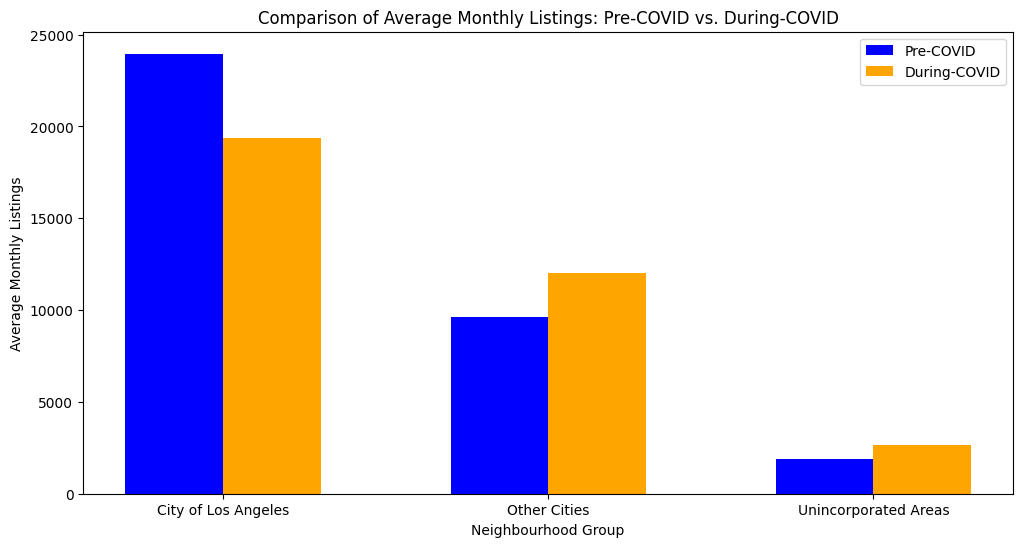

In [47]:
# Visualization
import matplotlib.pyplot as plt
import numpy as np

# Bar chart comparison
x = np.arange(len(listings_comparison['neighbourhood_group']))
width = 0.3

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, listings_comparison['Avg_Monthly_Listings_Pre_COVID'], width, label='Pre-COVID', color='blue')
plt.bar(x + width/2, listings_comparison['Avg_Monthly_Listings_During_COVID'], width, label='During-COVID', color='orange')


# Formatting
plt.xticks(x, listings_comparison['neighbourhood_group'])
plt.xlabel('Neighbourhood Group')
plt.ylabel('Average Monthly Listings')
plt.title('Comparison of Average Monthly Listings: Pre-COVID vs. During-COVID')
plt.legend()
plt.show()

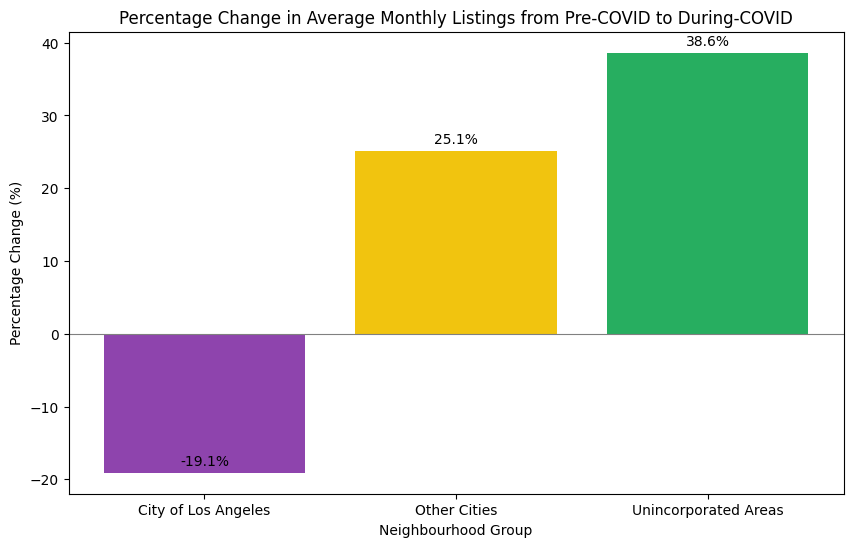

In [48]:
# Bar chart for percentage change in Avg_Monthly_Listings
plt.figure(figsize=(10, 6))
bars = plt.bar(
    listings_comparison['neighbourhood_group'],
    listings_comparison['Percentage_Change'],
    color=['#8e44ad', '#f1c40f', '#27ae60']
)

# Add percentage labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f"{height:.1f}%", ha='center', fontsize=10)

# Formatting the plot
plt.xlabel('Neighbourhood Group')
plt.ylabel('Percentage Change (%)')
plt.title('Percentage Change in Average Monthly Listings from Pre-COVID to During-COVID')
plt.axhline(0, color='gray', linewidth=0.8)  # Add horizontal line at y=0 for reference
plt.show()

In [49]:
# 1️⃣ Group by period, neighbourhood_group, and neighbourhood, then count the monthly listings
neighbourhood_listings = df_clean[df_clean['ComparisonPeriod'].isin([0, 1])].groupby(
    ['ComparisonPeriod', 'neighbourhood_group', 'neighbourhood']
).size().reset_index(name='Listing_Count')

# 2️⃣ Pivot table to compare pre-COVID and during-COVID periods
listing_pivot = neighbourhood_listings.pivot_table(
    index=['neighbourhood_group', 'neighbourhood'],
    columns='ComparisonPeriod',
    values='Listing_Count',
    fill_value=0
).reset_index()

# Rename columns for clarity
listing_pivot.columns = ['neighbourhood_group', 'neighbourhood', 'Pre_COVID_Listings', 'During_COVID_Listings']

# 3️⃣ Calculate percentage change and absolute change
listing_pivot['Percentage_Change'] = (
    (listing_pivot['During_COVID_Listings'] - listing_pivot['Pre_COVID_Listings']) / listing_pivot['Pre_COVID_Listings']
) * 100

listing_pivot['Absolute_Change'] = listing_pivot['During_COVID_Listings'] - listing_pivot['Pre_COVID_Listings']

# 4️⃣ Top 5 Neighbourhoods by group
# Top 5 absolute decreases for City of Los Angeles
la_top_decrease = listing_pivot[listing_pivot['neighbourhood_group'] == 'City of Los Angeles'] \
    .nsmallest(5, 'Absolute_Change')

# Top 5 percentage increases for Other Cities & Unincorporated Areas
other_cities_increase = listing_pivot[listing_pivot['neighbourhood_group'] == 'Other Cities'] \
    .nlargest(5, 'Percentage_Change')

unincorporated_increase = listing_pivot[listing_pivot['neighbourhood_group'] == 'Unincorporated Areas'] \
    .nlargest(5, 'Percentage_Change')

# 5️⃣ Display DataFrames
print("Top 5 Neighborhoods in City of Los Angeles with Largest Absolute Decrease:\n")
print(la_top_decrease[['neighbourhood', 'Pre_COVID_Listings', 'During_COVID_Listings', 'Absolute_Change', 'Percentage_Change']])

print("\nTop 5 Neighborhoods in Other Cities with Largest Percentage Increase:\n")
print(other_cities_increase[['neighbourhood', 'Pre_COVID_Listings', 'During_COVID_Listings', 'Absolute_Change', 'Percentage_Change']])

print("\nTop 5 Neighborhoods in Unincorporated Areas with Largest Percentage Increase:\n")
print(unincorporated_increase[['neighbourhood', 'Pre_COVID_Listings', 'During_COVID_Listings', 'Absolute_Change', 'Percentage_Change']])

Top 5 Neighborhoods in City of Los Angeles with Largest Absolute Decrease:

      neighbourhood  Pre_COVID_Listings  During_COVID_Listings  \
98           Venice            72121.00               18807.00   
47        Hollywood            70200.00               18648.00   
23         Downtown            39344.00               12825.00   
48  Hollywood Hills            27843.00                8544.00   
62     Mid-Wilshire            23908.00                5889.00   

    Absolute_Change  Percentage_Change  
98        -53314.00             -73.92  
47        -51552.00             -73.44  
23        -26519.00             -67.40  
48        -19299.00             -69.31  
62        -18019.00             -75.37  

Top 5 Neighborhoods in Other Cities with Largest Percentage Increase:

    neighbourhood  Pre_COVID_Listings  During_COVID_Listings  Absolute_Change  \
147  Hidden Hills                2.00                   5.00             3.00   
117       Artesia              170.00          

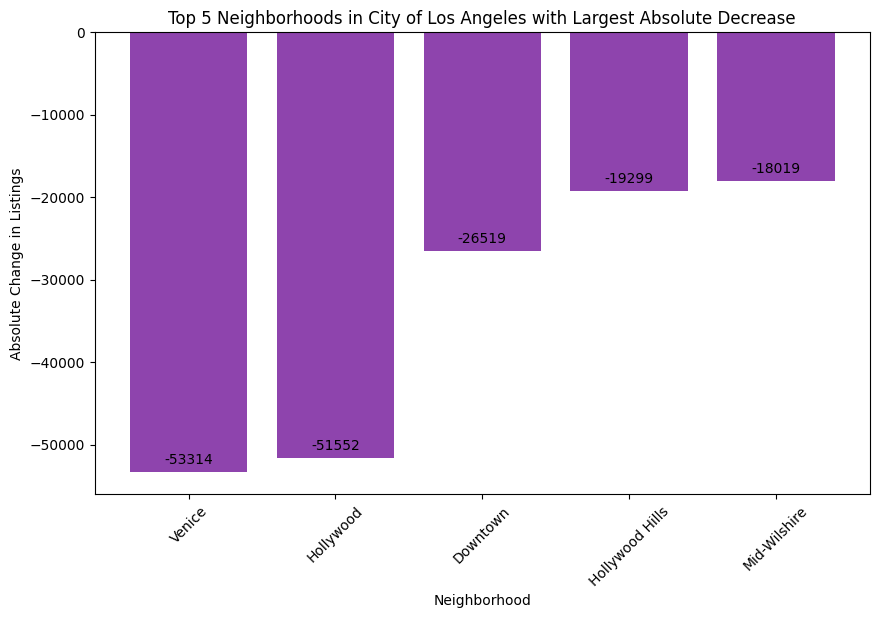

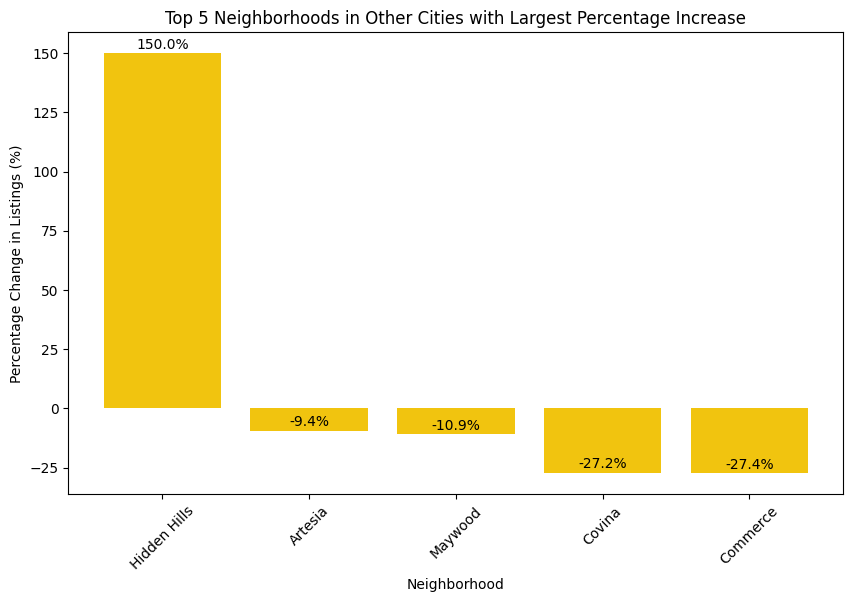

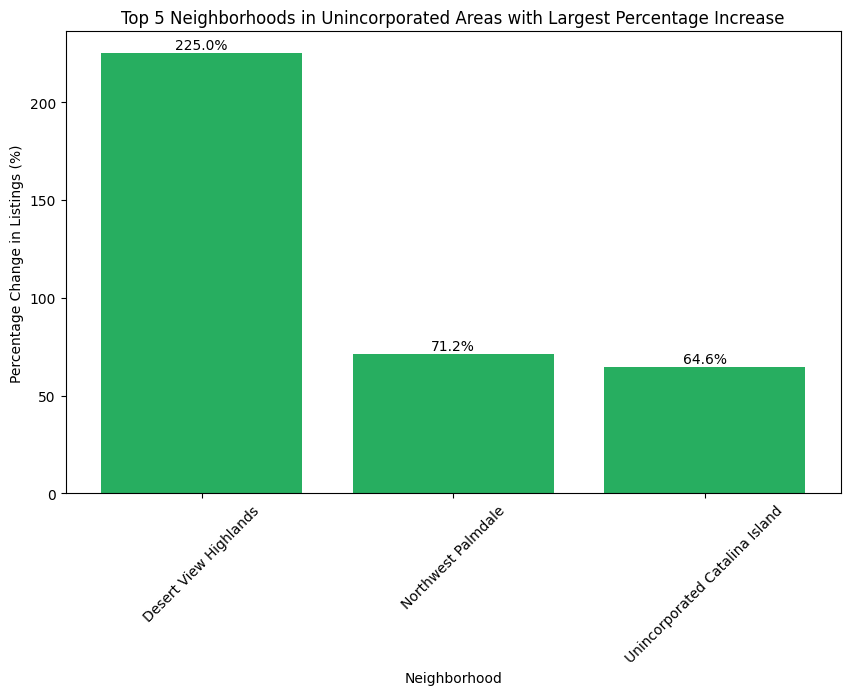

In [50]:
# 6️⃣ Visualizations

# City of LA - Absolute Decrease
plt.figure(figsize=(10, 6))
bars = plt.bar(
    la_top_decrease['neighbourhood'],
    la_top_decrease['Absolute_Change'],
    color='#8e44ad'
)
plt.title('Top 5 Neighborhoods in City of Los Angeles with Largest Absolute Decrease')
plt.xlabel('Neighborhood')
plt.ylabel('Absolute Change in Listings')
plt.xticks(rotation=45)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1000, f"{int(height)}", ha='center')
plt.show()

# Other Cities - Percentage Increase
plt.figure(figsize=(10, 6))
bars = plt.bar(
    other_cities_increase['neighbourhood'],
    other_cities_increase['Percentage_Change'],
    color='#f1c40f'
)
plt.title('Top 5 Neighborhoods in Other Cities with Largest Percentage Increase')
plt.xlabel('Neighborhood')
plt.ylabel('Percentage Change in Listings (%)')
plt.xticks(rotation=45)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 2, f"{height:.1f}%", ha='center')
plt.show()

# Unincorporated Areas - Percentage Increase
plt.figure(figsize=(10, 6))
bars = plt.bar(
    unincorporated_increase['neighbourhood'],
    unincorporated_increase['Percentage_Change'],
    color='#27ae60'
)
plt.title('Top 5 Neighborhoods in Unincorporated Areas with Largest Percentage Increase')
plt.xlabel('Neighborhood')
plt.ylabel('Percentage Change in Listings (%)')
plt.xticks(rotation=45)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 2, f"{height:.1f}%", ha='center')
plt.show()

### Analysis 8_Geographic impact analysis across variables: Avg_Availability (365 days)

In [51]:
# Filter for Pre-COVID and During-COVID separately
pre_covid_avail = geo_impact[geo_impact['ComparisonPeriod'] == 0][['neighbourhood_group', 'Avg_Availability']]
during_covid_avail = geo_impact[geo_impact['ComparisonPeriod'] == 1][['neighbourhood_group', 'Avg_Availability']]

# Merge to compare side by side
availability_comparison = pre_covid_avail.merge(
    during_covid_avail, on='neighbourhood_group', suffixes=('_Pre_COVID', '_During_COVID')
)

# Calculate percentage change for better interpretation
availability_comparison['Percentage_Change'] = (
    (availability_comparison['Avg_Availability_During_COVID'] - availability_comparison['Avg_Availability_Pre_COVID']) /
    availability_comparison['Avg_Availability_Pre_COVID']
) * 100

# Display the DataFrame in a clear format
pd.set_option('display.float_format', '{:.2f}'.format)
availability_comparison.reset_index(drop=True, inplace=True)
availability_comparison

,neighbourhood_group,Avg_Availability_Pre_COVID,Avg_Availability_During_COVID,Percentage_Change
0,City of Los Angeles,178.00,170.74,-4.08
1,Other Cities,192.03,163.62,-14.79
2,Unincorporated Areas,199.35,173.26,-13.09


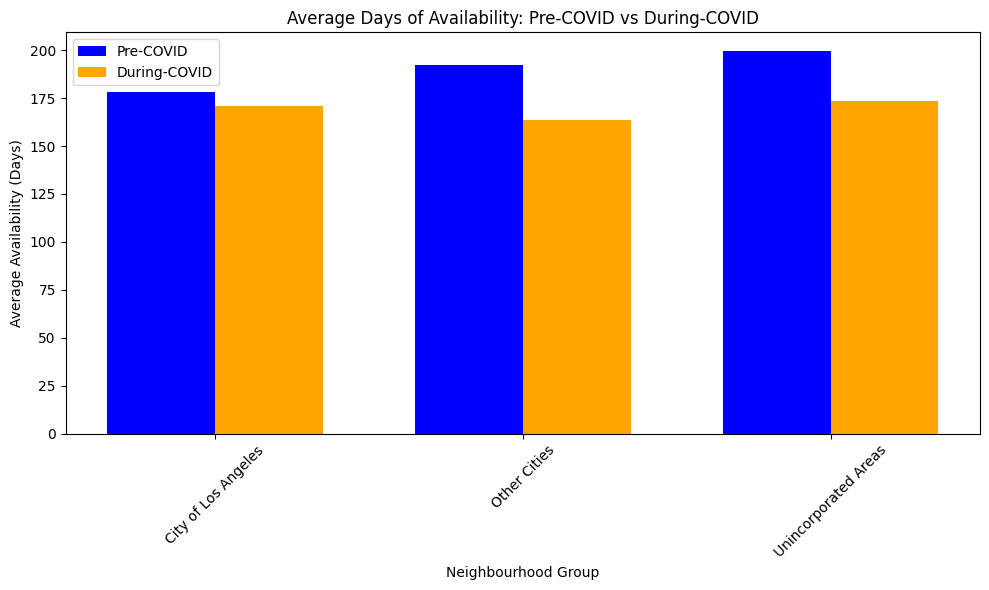

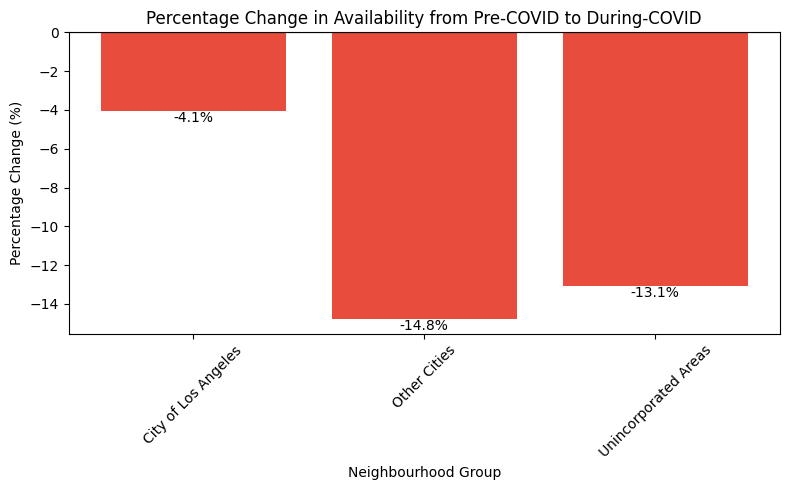

In [52]:
# Data for visualization
neighbourhoods = availability_comparison['neighbourhood_group']
pre_covid_avail = availability_comparison['Avg_Availability_Pre_COVID']
during_covid_avail = availability_comparison['Avg_Availability_During_COVID']
percentage_change = availability_comparison['Percentage_Change']

# 1️⃣ Side-by-Side Bar Chart: Average Availability Before and During COVID
x = np.arange(len(neighbourhoods))  # label locations
width = 0.35  # bar width

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, pre_covid_avail, width, label='Pre-COVID', color='blue')
plt.bar(x + width/2, during_covid_avail, width, label='During-COVID', color='orange')
plt.xticks(x, neighbourhoods, rotation=45)
plt.xlabel('Neighbourhood Group')
plt.ylabel('Average Availability (Days)')
plt.title('Average Days of Availability: Pre-COVID vs During-COVID')
plt.legend()
plt.tight_layout()
plt.show()

# 2️⃣ Percentage Change Bar Chart
plt.figure(figsize=(8, 5))
bars = plt.bar(neighbourhoods, percentage_change, color=['#ffccab' if val >= 0 else '#e74c3c' for val in percentage_change]) # Peach for increase, Red for decrease
plt.axhline(0, color='black', linewidth=0.8)  # Reference line at 0
plt.xlabel('Neighbourhood Group')
plt.ylabel('Percentage Change (%)')
plt.title('Percentage Change in Availability from Pre-COVID to During-COVID')
plt.xticks(rotation=45)

# Add percentage labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%', ha='center', va='bottom' if height > 0 else 'top')

plt.tight_layout()
plt.show()

### Analysis 8_Geographic impact analysis across variables: Avg_Min_Nights

In [53]:
# Filter for Pre-COVID and During-COVID separately
pre_covid_min_nights = geo_impact[geo_impact['ComparisonPeriod'] == 0][['neighbourhood_group', 'Avg_Min_Nights']]
during_covid_min_nights = geo_impact[geo_impact['ComparisonPeriod'] == 1][['neighbourhood_group', 'Avg_Min_Nights']]

# Merge to compare side by side
min_nights_comparison = pre_covid_min_nights.merge(
    during_covid_min_nights, on='neighbourhood_group', suffixes=('_Pre_COVID', '_During_COVID')
)

# Calculate percentage change for better interpretation
min_nights_comparison['Percentage_Change'] = (
    (min_nights_comparison['Avg_Min_Nights_During_COVID'] - min_nights_comparison['Avg_Min_Nights_Pre_COVID']) /
    min_nights_comparison['Avg_Min_Nights_Pre_COVID']
) * 100

# Display the DataFrame in a clear format
pd.set_option('display.float_format', '{:.2f}'.format)
min_nights_comparison.reset_index(drop=True, inplace=True)
print(min_nights_comparison)

    neighbourhood_group  Avg_Min_Nights_Pre_COVID  \
0   City of Los Angeles                      4.32   
1          Other Cities                      5.84   
2  Unincorporated Areas                      3.50   

   Avg_Min_Nights_During_COVID  Percentage_Change  
0                        19.71             356.63  
1                         9.89              69.44  
2                         7.11             103.06  


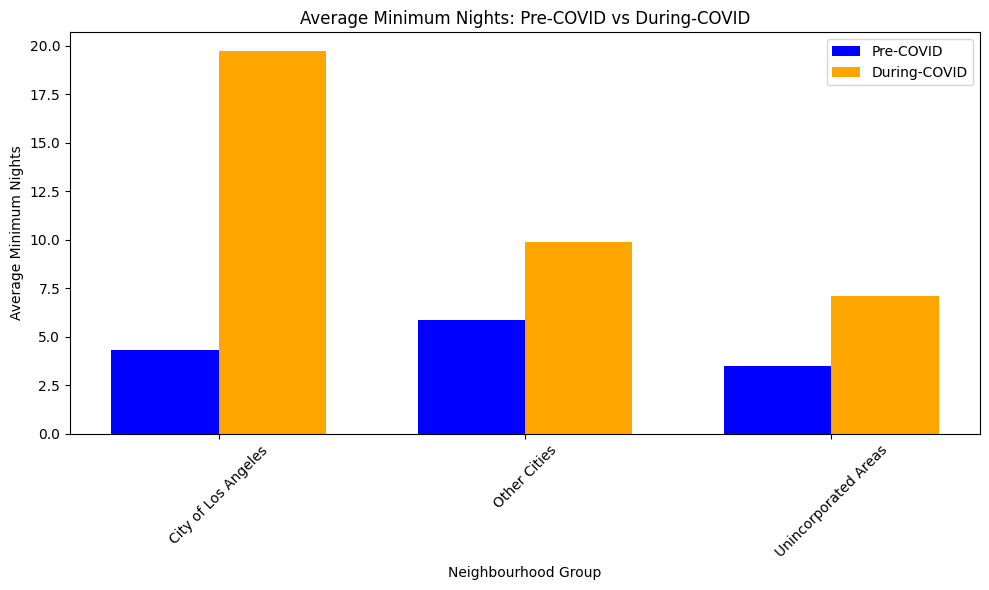

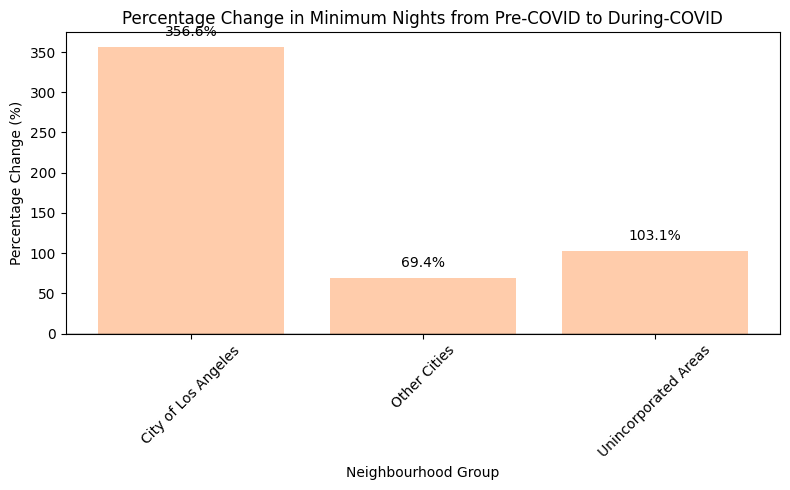

In [54]:
# Define variables for plotting from the DataFrame
neighbourhoods = min_nights_comparison['neighbourhood_group']
pre_covid_min = min_nights_comparison['Avg_Min_Nights_Pre_COVID']
during_covid_min = min_nights_comparison['Avg_Min_Nights_During_COVID']
percentage_change = min_nights_comparison['Percentage_Change']

# 1️⃣ Side-by-Side Bar Chart: Average Minimum Nights Before and During COVID
x = np.arange(len(neighbourhoods))  # label locations
width = 0.35  # bar width

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, pre_covid_min, width, label='Pre-COVID', color='blue')
plt.bar(x + width/2, during_covid_min, width, label='During-COVID', color='orange')
plt.xticks(x, neighbourhoods, rotation=45)
plt.xlabel('Neighbourhood Group')
plt.ylabel('Average Minimum Nights')
plt.title('Average Minimum Nights: Pre-COVID vs During-COVID')
plt.legend()
plt.tight_layout()
plt.show()

# 2️⃣ Percentage Change Bar Chart
plt.figure(figsize=(8, 5))
bars = plt.bar(
    neighbourhoods,
    percentage_change,
    color=['#ffccab' if val >= 0 else '#e74c3c' for val in percentage_change]  # Peach for increase, Red for decrease
)

# Add a reference horizontal line at 0
plt.axhline(0, color='black', linewidth=1)

# Add labels for each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 10,  # Adjust label position for clarity
        f'{height:.1f}%',
        ha='center',
        va='bottom'
    )

# Formatting
plt.xlabel('Neighbourhood Group')
plt.ylabel('Percentage Change (%)')
plt.title('Percentage Change in Minimum Nights from Pre-COVID to During-COVID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [55]:
# Count total listings per neighbourhood_group before COVID
pre_covid_listing_volume = df_clean[df_clean['ComparisonPeriod'] == 0].groupby('neighbourhood_group').size().reset_index(name='Pre_COVID_Listings')

# Merge with minimum nights comparison to analyze potential influence
min_nights_with_volume = min_nights_comparison.merge(pre_covid_listing_volume, on='neighbourhood_group')

# Display the result
print("Initial Listings Volume and Percentage Change in Minimum Nights:\n")
print(min_nights_with_volume)

Initial Listings Volume and Percentage Change in Minimum Nights:

    neighbourhood_group  Avg_Min_Nights_Pre_COVID  \
0   City of Los Angeles                      4.32   
1          Other Cities                      5.84   
2  Unincorporated Areas                      3.50   

   Avg_Min_Nights_During_COVID  Percentage_Change  Pre_COVID_Listings  
0                        19.71             356.63              742677  
1                         9.89              69.44              298015  
2                         7.11             103.06               58991  


### Analysis 8_Geographic impact analysis across variables: Avg_Price

In [56]:
# 1️⃣ Filter for Pre-COVID and During-COVID separately
pre_covid_price = geo_impact[geo_impact['ComparisonPeriod'] == 0][['neighbourhood_group', 'Avg_Price']]
during_covid_price = geo_impact[geo_impact['ComparisonPeriod'] == 1][['neighbourhood_group', 'Avg_Price']]

# 2️⃣ Merge to compare side by side
price_comparison = pre_covid_price.merge(
    during_covid_price, on='neighbourhood_group', suffixes=('_Pre_COVID', '_During_COVID')
)

# 3️⃣ Calculate percentage change for better interpretation
price_comparison['Percentage_Change'] = (
    (price_comparison['Avg_Price_During_COVID'] - price_comparison['Avg_Price_Pre_COVID']) /
    price_comparison['Avg_Price_Pre_COVID']
) * 100

# 4️⃣ Display the DataFrame in a clear format
pd.set_option('display.float_format', '{:.2f}'.format)
price_comparison.reset_index(drop=True, inplace=True)
print(price_comparison)

    neighbourhood_group  Avg_Price_Pre_COVID  Avg_Price_During_COVID  \
0   City of Los Angeles               191.99                  224.32   
1          Other Cities               209.56                  238.75   
2  Unincorporated Areas               169.03                  178.57   

   Percentage_Change  
0              16.84  
1              13.93  
2               5.65  


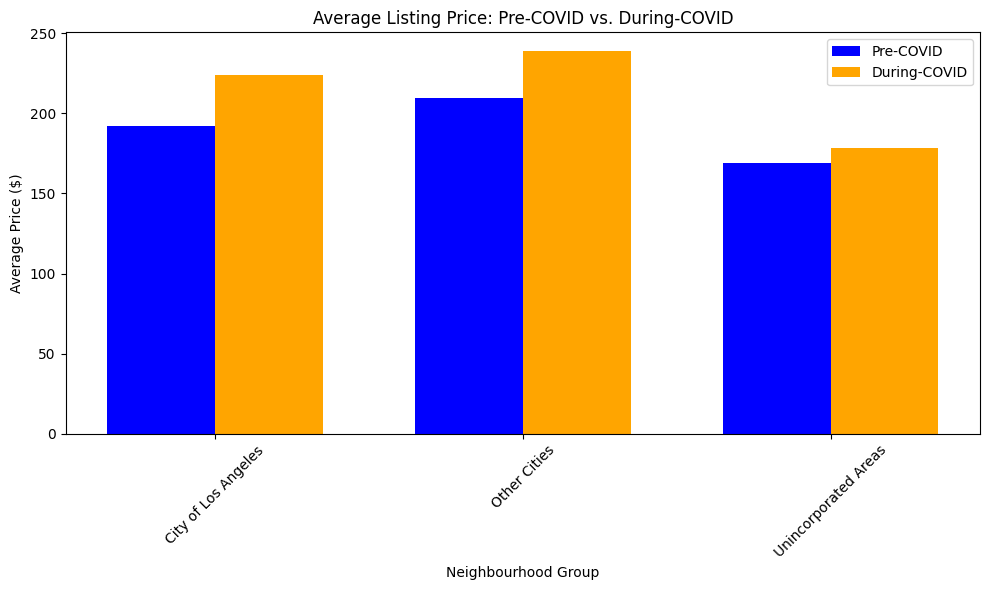

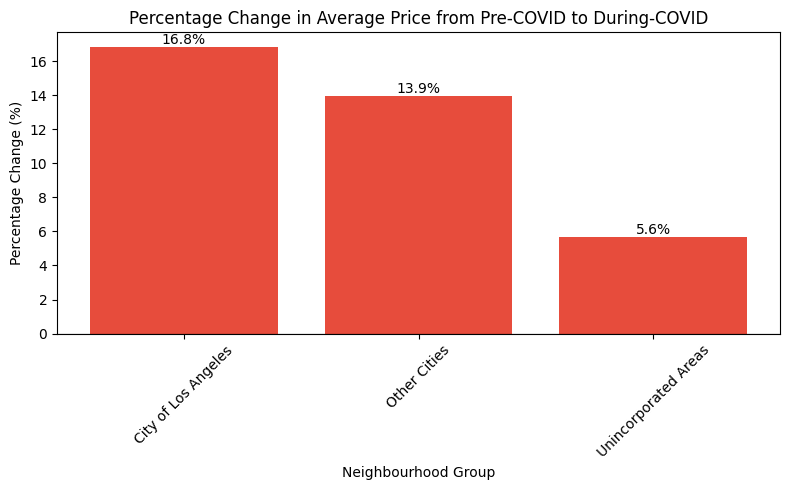

In [57]:
# 5️⃣ Visualization

# Data for visualization
neighbourhoods = price_comparison['neighbourhood_group']
pre_covid_prices = price_comparison['Avg_Price_Pre_COVID']
during_covid_prices = price_comparison['Avg_Price_During_COVID']
percentage_change = price_comparison['Percentage_Change']

# Side-by-Side Bar Chart: Average Price Before and During COVID
x = np.arange(len(neighbourhoods))  # label locations
width = 0.35  # bar width

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, pre_covid_prices, width, label='Pre-COVID', color='blue')  # Blue
plt.bar(x + width/2, during_covid_prices, width, label='During-COVID', color='orange')  # Orange
plt.xticks(x, neighbourhoods, rotation=45)
plt.xlabel('Neighbourhood Group')
plt.ylabel('Average Price ($)')
plt.title('Average Listing Price: Pre-COVID vs. During-COVID')
plt.legend()
plt.tight_layout()
plt.show()

# Percentage Change Bar Chart
plt.figure(figsize=(8, 5))
bars = plt.bar(neighbourhoods, percentage_change, color=['#ffccab' if val < 0 else '#e74c3c' for val in percentage_change])  # Peach for increase, Red for decrease
plt.axhline(0, color='black', linewidth=0.8)  # Reference line at 0
plt.xlabel('Neighbourhood Group')
plt.ylabel('Percentage Change (%)')
plt.title('Percentage Change in Average Price from Pre-COVID to During-COVID')
plt.xticks(rotation=45)

# Add percentage labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', ha='center', va='bottom' if height > 0 else 'top')

plt.tight_layout()
plt.show()

### Analysis 8_Geographic impact analysis across variables: Avg_Reviews_Per_Month

In [58]:
# 1️⃣ Filter for Pre-COVID and During-COVID separately
pre_covid_reviews = geo_impact[geo_impact['ComparisonPeriod'] == 0][['neighbourhood_group', 'Avg_Reviews_Per_Month']]
during_covid_reviews = geo_impact[geo_impact['ComparisonPeriod'] == 1][['neighbourhood_group', 'Avg_Reviews_Per_Month']]

# 2️⃣ Merge to compare side by side
reviews_comparison = pre_covid_reviews.merge(
    during_covid_reviews, on='neighbourhood_group', suffixes=('_Pre_COVID', '_During_COVID')
)

# 3️⃣ Calculate percentage change for better interpretation
reviews_comparison['Percentage_Change'] = (
    (reviews_comparison['Avg_Reviews_Per_Month_During_COVID'] - reviews_comparison['Avg_Reviews_Per_Month_Pre_COVID']) /
    reviews_comparison['Avg_Reviews_Per_Month_Pre_COVID']
) * 100

# 4️⃣ Display the DataFrame in a clear format
pd.set_option('display.float_format', '{:.2f}'.format)
reviews_comparison.reset_index(drop=True, inplace=True)
print(reviews_comparison)

    neighbourhood_group  Avg_Reviews_Per_Month_Pre_COVID  \
0   City of Los Angeles                             1.50   
1          Other Cities                             1.43   
2  Unincorporated Areas                             1.45   

   Avg_Reviews_Per_Month_During_COVID  Percentage_Change  
0                                1.15             -22.94  
1                                1.27             -11.40  
2                                1.43              -1.62  


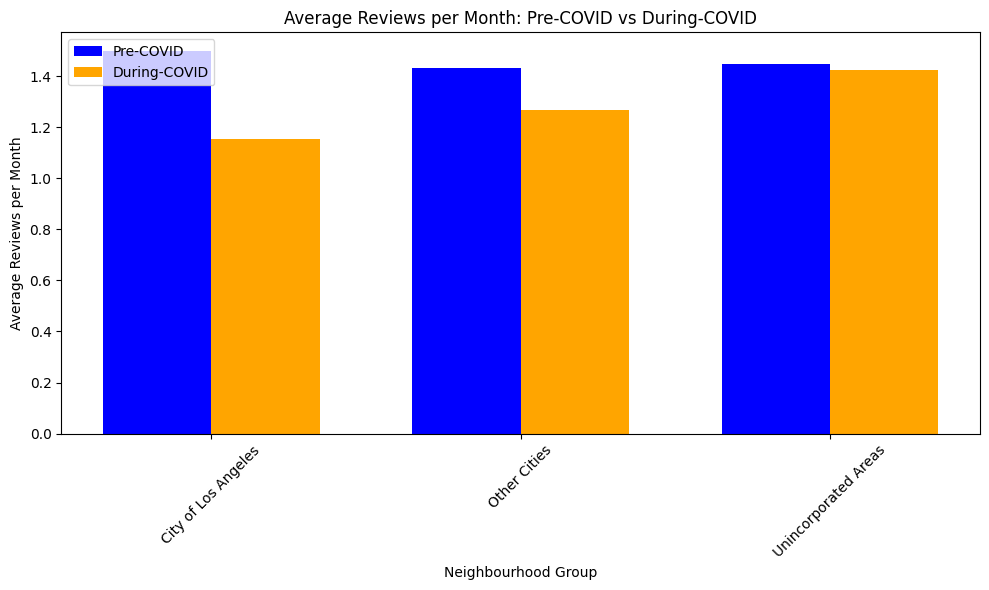

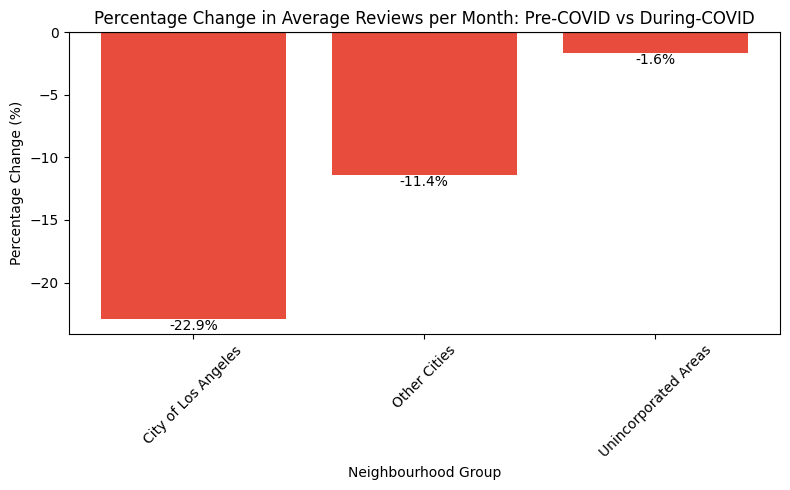

In [59]:
# 5️⃣ Visualization - Side-by-Side Bar Chart: Average Reviews per Month Before and During COVID
neighbourhoods = reviews_comparison['neighbourhood_group']
pre_covid_reviews_avg = reviews_comparison['Avg_Reviews_Per_Month_Pre_COVID']
during_covid_reviews_avg = reviews_comparison['Avg_Reviews_Per_Month_During_COVID']
percentage_change = reviews_comparison['Percentage_Change']

x = np.arange(len(neighbourhoods))  # label locations
width = 0.35  # bar width

# Side-by-Side Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, pre_covid_reviews_avg, width, label='Pre-COVID', color='blue')  # Purple shade
plt.bar(x + width/2, during_covid_reviews_avg, width, label='During-COVID', color='orange')  # Amber shade
plt.xticks(x, neighbourhoods, rotation=45)
plt.xlabel('Neighbourhood Group')
plt.ylabel('Average Reviews per Month')
plt.title('Average Reviews per Month: Pre-COVID vs During-COVID')
plt.legend()
plt.tight_layout()
plt.show()

# 6️⃣ Percentage Change Bar Chart
plt.figure(figsize=(8, 5))
bars = plt.bar(
    neighbourhoods, percentage_change, color=['#ffccab' if val >= 0 else '#e74c3c' for val in percentage_change]  # Peach for increase, Red for decrease
)
plt.axhline(0, color='black', linewidth=0.8)  # Reference line at 0%
plt.xlabel('Neighbourhood Group')
plt.ylabel('Percentage Change (%)')
plt.title('Percentage Change in Average Reviews per Month: Pre-COVID vs During-COVID')
plt.xticks(rotation=45)

# Add percentage labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%', ha='center', va='bottom' if height > 0 else 'top')

plt.tight_layout()
plt.show()

### Analysis 8_Geographic impact analysis across variables: Proportion_Entire_Space

In [60]:
# 1️⃣ Filter for Pre-COVID and During-COVID separately
pre_covid_entire_space = geo_impact[geo_impact['ComparisonPeriod'] == 0][['neighbourhood_group', 'Proportion_Entire_Space']]
during_covid_entire_space = geo_impact[geo_impact['ComparisonPeriod'] == 1][['neighbourhood_group', 'Proportion_Entire_Space']]

# 2️⃣ Merge to compare side by side
entire_space_comparison = pre_covid_entire_space.merge(
    during_covid_entire_space, on='neighbourhood_group', suffixes=('_Pre_COVID', '_During_COVID')
)

# 3️⃣ Calculate percentage change
entire_space_comparison['Percentage_Change'] = (
    (entire_space_comparison['Proportion_Entire_Space_During_COVID'] - entire_space_comparison['Proportion_Entire_Space_Pre_COVID']) /
    entire_space_comparison['Proportion_Entire_Space_Pre_COVID']
) * 100

# 4️⃣ Display DataFrame
pd.set_option('display.float_format', '{:.2f}'.format)
entire_space_comparison.reset_index(drop=True, inplace=True)
print(entire_space_comparison)

    neighbourhood_group  Proportion_Entire_Space_Pre_COVID  \
0   City of Los Angeles                               0.65   
1          Other Cities                               0.55   
2  Unincorporated Areas                               0.52   

   Proportion_Entire_Space_During_COVID  Percentage_Change  
0                                  0.69               6.38  
1                                  0.59               7.35  
2                                  0.54               4.59  


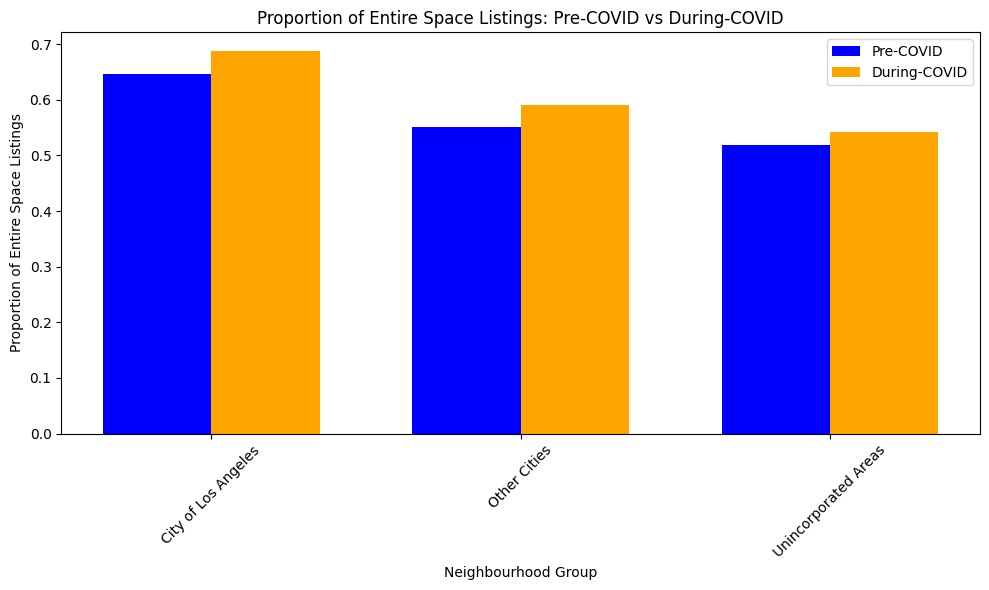

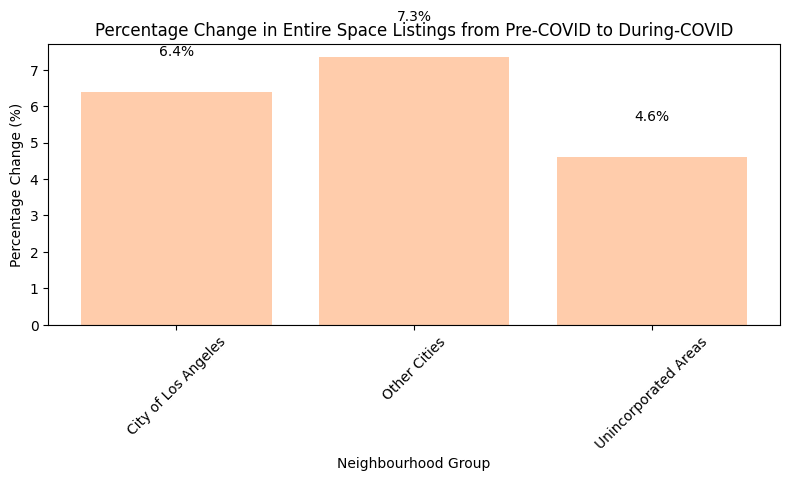

In [61]:
# 5️⃣ Visualization

# Side-by-side bar chart comparing pre and during COVID proportions
neighbourhoods = entire_space_comparison['neighbourhood_group']
pre_covid_space = entire_space_comparison['Proportion_Entire_Space_Pre_COVID']
during_covid_space = entire_space_comparison['Proportion_Entire_Space_During_COVID']
percentage_change = entire_space_comparison['Percentage_Change']

# Bar chart for proportion before and during COVID
x = np.arange(len(neighbourhoods))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, pre_covid_space, width, label='Pre-COVID', color='blue')  # Teal color
plt.bar(x + width/2, during_covid_space, width, label='During-COVID', color='orange')  # Yellow-orange color
plt.xticks(x, neighbourhoods, rotation=45)
plt.xlabel('Neighbourhood Group')
plt.ylabel('Proportion of Entire Space Listings')
plt.title('Proportion of Entire Space Listings: Pre-COVID vs During-COVID')
plt.legend()
plt.tight_layout()
plt.show()

# Bar chart for percentage change
plt.figure(figsize=(8, 5))
bars = plt.bar(
    neighbourhoods, percentage_change,
    color=['#ffccab' if val >= 0 else '#e74c3c' for val in percentage_change]  # Peach for increase, Red for decrease
)
plt.axhline(0, color='gray', linewidth=0.8)
plt.xlabel('Neighbourhood Group')
plt.ylabel('Percentage Change (%)')
plt.title('Percentage Change in Entire Space Listings from Pre-COVID to During-COVID')
plt.xticks(rotation=45)

# Add percentage labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [62]:
# Calculate room proportions for each neighbourhood group and period
room_proportions = df_clean[df_clean['ComparisonPeriod'].isin([0, 1])].groupby(
    ['ComparisonPeriod', 'neighbourhood_group', 'room_category']
).size().unstack(fill_value=0)

# Calculate proportions
room_proportions = room_proportions.div(room_proportions.sum(axis=1), axis=0).reset_index()

# Pivot the table for easier comparison
room_proportion_pivot = room_proportions.pivot_table(
    index='neighbourhood_group',
    columns='ComparisonPeriod',
    values='Room'
).reset_index()

# Rename columns for clarity
room_proportion_pivot.columns = ['neighbourhood_group', 'Pre_COVID_Rooms', 'During_COVID_Rooms']

# Calculate percentage change
room_proportion_pivot['Percentage_Change'] = (
    (room_proportion_pivot['During_COVID_Rooms'] - room_proportion_pivot['Pre_COVID_Rooms']) / room_proportion_pivot['Pre_COVID_Rooms']
) * 100

# Display the DataFrame
pd.set_option('display.float_format', '{:.2f}'.format)
room_proportion_pivot

,neighbourhood_group,Pre_COVID_Rooms,During_COVID_Rooms,Percentage_Change
0,City of Los Angeles,0.35,0.31,-11.63
1,Other Cities,0.45,0.41,-9.01
2,Unincorporated Areas,0.48,0.46,-4.95


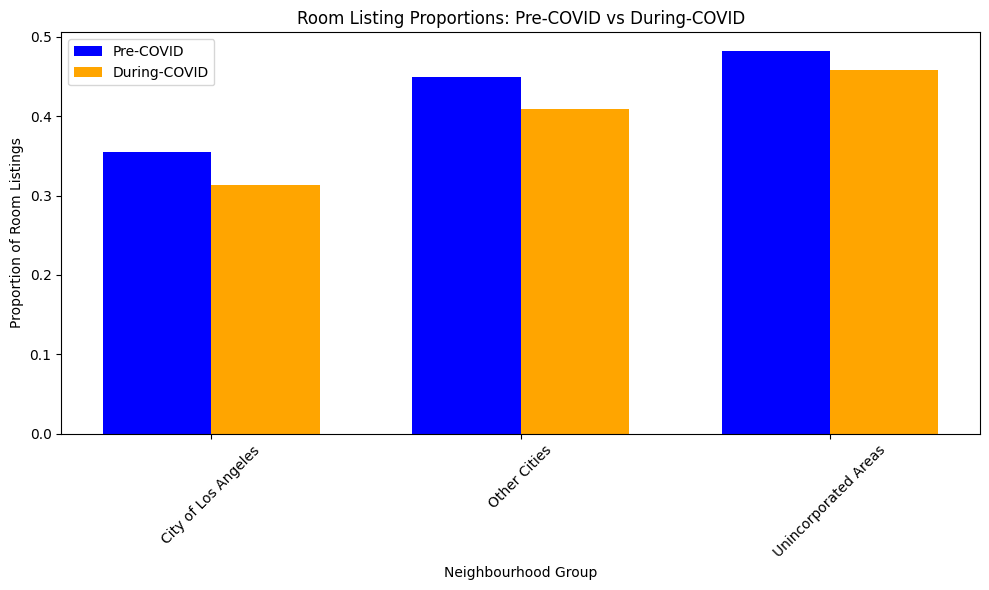

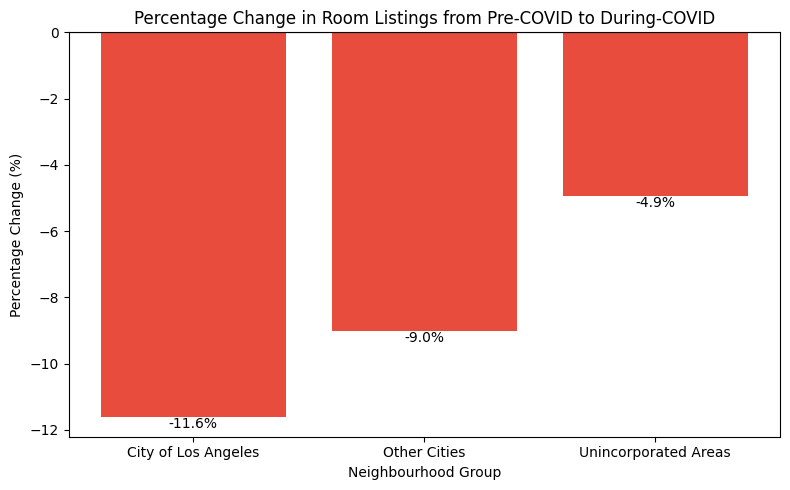

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Data for visualization
neighbourhoods = room_proportion_pivot['neighbourhood_group']
pre_covid_rooms = room_proportion_pivot['Pre_COVID_Rooms']
during_covid_rooms = room_proportion_pivot['During_COVID_Rooms']
percentage_change = room_proportion_pivot['Percentage_Change']

# 1️⃣ Side-by-Side Bar Chart
x = np.arange(len(neighbourhoods))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, pre_covid_rooms, width, label='Pre-COVID', color='blue')
plt.bar(x + width/2, during_covid_rooms, width, label='During-COVID', color='orange')

# Formatting
plt.xticks(x, neighbourhoods, rotation=45)
plt.xlabel('Neighbourhood Group')
plt.ylabel('Proportion of Room Listings')
plt.title('Room Listing Proportions: Pre-COVID vs During-COVID')
plt.legend()
plt.tight_layout()
plt.show()

# 2️⃣ Percentage Change Bar Chart
plt.figure(figsize=(8, 5))
bars = plt.bar(
    neighbourhoods, percentage_change,
    color=['#3498db' if val >= 0 else '#e74c3c' for val in percentage_change]
)

# Add percentage labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%', ha='center', va='bottom' if height > 0 else 'top')

plt.axhline(0, color='black', linewidth=0.8)
plt.xlabel('Neighbourhood Group')
plt.ylabel('Percentage Change (%)')
plt.title('Percentage Change in Room Listings from Pre-COVID to During-COVID')
plt.tight_layout()
plt.show()

# Map

In [3]:
import requests

url = 'https://raw.githubusercontent.com/blackmad/neighborhoods/master/los-angeles.geojson'
response = requests.get(url)
la_geojson = response.json()

In [17]:
import requests
import json
import pandas as pd
import plotly.express as px

# Load the GeoJSON file for Los Angeles neighborhoods
url = 'https://raw.githubusercontent.com/blackmad/neighborhoods/master/los-angeles.geojson'
response = requests.get(url)
la_geojson = response.json()

# Suppose your Airbnb data is in a DataFrame called df_airbnb:
# df_airbnb = pd.read_csv("path_to_your_airbnb_data.csv")

# Ensure the column names are consistent (e.g., use 'neighborhood')
# Merge GeoJSON with Airbnb data: update references from df_clean to df_airbnb
for feature in la_geojson['features']:
    feature_name = feature['properties']['name']
    if feature_name in df_clean['neighbourhood'].values:
        feature['properties']['price_change_percentage'] = df_clean.loc[
            df_clean['neighbourhood'] == feature_name, 'price_change_percentage'
        ].values[0]
    else:
        feature['properties']['price_change_percentage'] = None

# Create DataFrame for Plotly
plotly_data = pd.DataFrame([
    {
        'neighbourhood': feature['properties']['name'],
        'price_change_percentage': feature['properties']['price_change_percentage']
    }
    for feature in la_geojson['features']
])

# Drop rows with None values
plotly_data = plotly_data.dropna(subset=['price_change_percentage'])

# Create the choropleth map
fig = px.choropleth_mapbox(
    plotly_data,
    geojson=la_geojson,
    locations='neighbourhood',
    featureidkey='properties.name',
    color='price_change_percentage',
    color_continuous_scale="Viridis",
    range_color=(-10, 10),  # Adjust based on your data range
    mapbox_style="carto-positron",
    zoom=10,
    center={"lat": 34.0522, "lon": -118.2437},
    opacity=0.5,
    labels={'price_change_percentage': 'Price Change (%)'},
    title="Airbnb Price Change Percentage by Neighborhood"
)

fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.show()

KeyError: 'price_change_percentage'